## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-03-15 15:30:18.726215


{1: 24.0,
 5: 25.3,
 10: 26.1,
 20: 27.0,
 30: 28.3,
 40: 30.1,
 50: 31.9,
 60: 33.7,
 70: 35.7,
 80: 38.2,
 90: 41.6,
 95: 44.5,
 99: 50.0}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-03-15 12:27:41.902659


{1: 8.0,
 5: 8.2,
 10: 8.4,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 9.1,
 60: 9.2,
 70: 9.4,
 80: 9.6,
 90: 9.9,
 95: 10.1,
 99: 10.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-03-18 14:27:37.133234


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.5),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 48037.68it/s]


{1: 0.00071,
 5: 0.00107,
 10: 0.00134,
 20: 0.00175,
 30: 0.00216,
 40: 0.00259,
 50: 0.0031,
 60: 0.00385,
 70: 0.00494,
 80: 0.00772,
 90: 0.01189,
 95: 0.0149,
 99: 0.02031}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.071%',
 5: '0.107%',
 10: '0.134%',
 20: '0.175%',
 30: '0.216%',
 40: '0.259%',
 50: '0.31%',
 60: '0.385%',
 70: '0.494%',
 80: '0.772%',
 90: '1.189%',
 95: '1.49%',
 99: '2.031%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '17.9 billion',
 5: '26.8 billion',
 10: '33.5 billion',
 20: '44.0 billion',
 30: '54.3 billion',
 40: '64.8 billion',
 50: '77.9 billion',
 60: '96.6 billion',
 70: '123.4 billion',
 80: '194.0 billion',
 90: '298.7 billion',
 95: '372.7 billion',
 99: '511.1 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 907582.98it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00026,
 60: 0.00038,
 70: 0.00058,
 80: 0.00096,
 90: 0.0018,
 95: 0.003,
 99: 0.00771}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.026%',
 60: '0.038%',
 70: '0.058%',
 80: '0.096%',
 90: '0.18%',
 95: '0.3%',
 99: '0.771%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.4 billion',
 60: '9.6 billion',
 70: '14.7 billion',
 80: '24.3 billion',
 90: '45.2 billion',
 95: '75.3 billion',
 99: '193.2 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 32.7 log FLOP (~501.2 nonillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~126.3 sextillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~2.1 billion).
* This doubles every 2.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.026x per year.
---
2024 - TAI takes 32.7 logFLOP which costs 14.1 log 2024$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 32.2 logFLOP which costs 13.6 log 2024$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 28.4 2024-log-eFLOP)
2026 - TAI takes 31.8 logFLOP which costs 13.0 log 2024$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 29.0 2024-log-eFLOP)
2027 - TAI takes 31.4 logFLOP which costs 12.5 

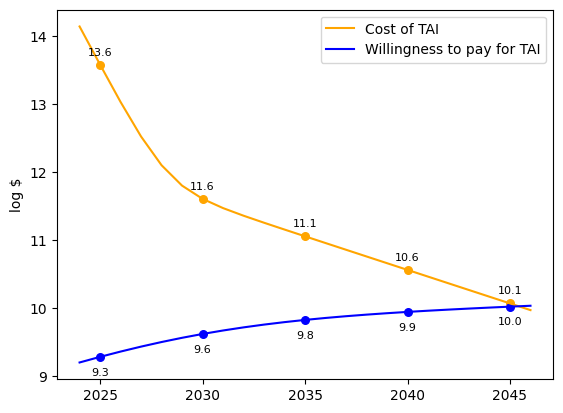



## SAMPLE RUN 2 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.3 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~510.1 sextillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~2.1 billion).
* This doubles every 7.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.019x per year.
---
2024 - TAI takes 32.8 logFLOP which costs 13.9 log 2024$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2024-log-eFLOP)
2025 - TAI takes 32.5 logFLOP which costs 13.5 log 2024$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 32.2 logFLOP which costs 13.0 log 2024$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 29.0 2024-log-eFLOP)
2027 - TAI takes 31.9 logFLOP which costs 12.6 

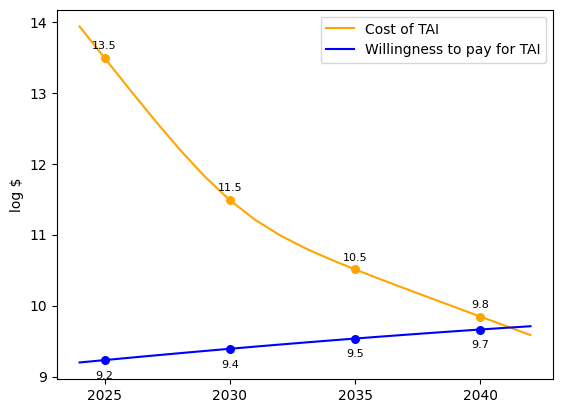



## SAMPLE RUN 3 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~25.7 quintillion) per 2024$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.2 septillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~2.9 billion).
* This doubles every 2.2 year to a max of 0.027391% of GDP (initially ~6.9 billion 2024$USD).
* GDP grows at a rate of 1.03x per year.
---
2024 - TAI takes 27.6 logFLOP which costs 8.2 log 2024$USD to buy vs. WTP at 9.3 (buys 28.7 log FLOP or 28.7 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- ro

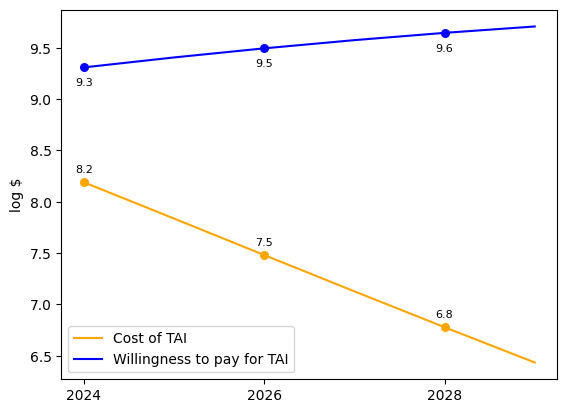



## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.67it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 609.69it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2035',
 '35%: 2039',
 '50%: 2046',
 '60%: 2052',
 '75%: 2079',
 '80%: >2124',
 '90%: >2124',
 '95%: >2124']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 6 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 11 years from now',
 '35%: 15 years from now',
 '50%: 22 years from now',
 '60%: 28 years from now',
 '75%: 55 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 38 years from now)


## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2025-2026: 0.6%
2027-2029: 4.2%
2030-2034: 17.5%
2035-2039: 15.1%
2040-2049: 18.7%
2050-2059: 11.4%
2060-2069: 4.9%
2070-2079: 2.8%
2080-2089: 1.8%
2090-2099: 0.8%
2100-2109: 0.8%
2110-2119: 0.4



## GDP Over Time ##
Year: 2024 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2025 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~26.2 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~28.0 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.2 trillion)
Year: 2030 - GDP log 2024$USD 13.5 (~28.6 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~30.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~29.2 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.9 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.8 trillion)
Year: 2033 - GDP log 2024$USD 13.

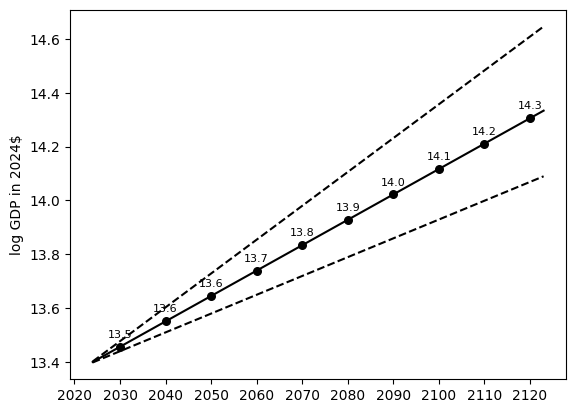

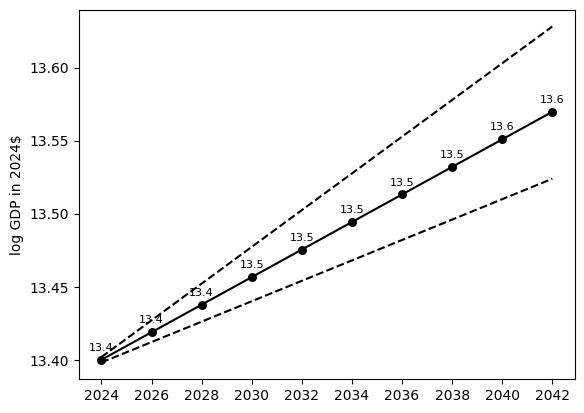



## Willingness to Pay Over Time ##
Year: 2024 - willingness log 2024$USD per year 9.0 (~1.1 billion) 80% CI 8.6 (~374.3 million) - 9.5 (~3.4 billion)
Year: 2025 - willingness log 2024$USD per year 9.1 (~1.3 billion) 80% CI 8.7 (~551.0 million) - 9.6 (~3.9 billion)
Year: 2026 - willingness log 2024$USD per year 9.2 (~1.6 billion) 80% CI 8.9 (~800.9 million) - 9.6 (~4.4 billion)
Year: 2027 - willingness log 2024$USD per year 9.3 (~1.9 billion) 80% CI 9.1 (~1.1 billion) - 9.7 (~5.0 billion)
Year: 2028 - willingness log 2024$USD per year 9.4 (~2.3 billion) 80% CI 9.2 (~1.6 billion) - 9.7 (~5.6 billion)
Year: 2029 - willingness log 2024$USD per year 9.4 (~2.7 billion) 80% CI 9.3 (~2.2 billion) - 9.8 (~6.3 billion)
Year: 2030 - willingness log 2024$USD per year 9.5 (~3.2 billion) 80% CI 9.5 (~2.8 billion) - 9.8 (~7.1 billion)
Year: 2031 - willingness log 2024$USD per year 9.6 (~3.7 billion) 80% CI 9.6 (~3.6 billion) - 9.9 (~7.9 billion)
Year: 2032 - willingness log 2024$USD per year 9.6 (~

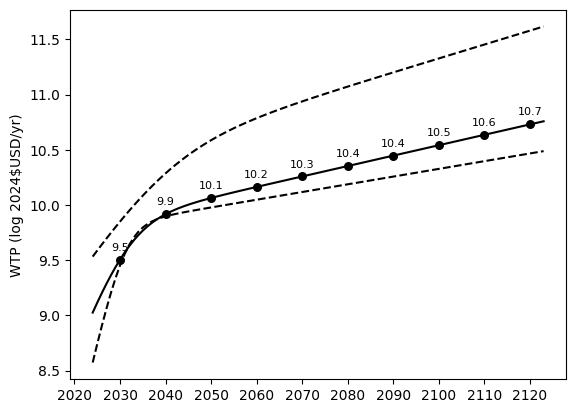

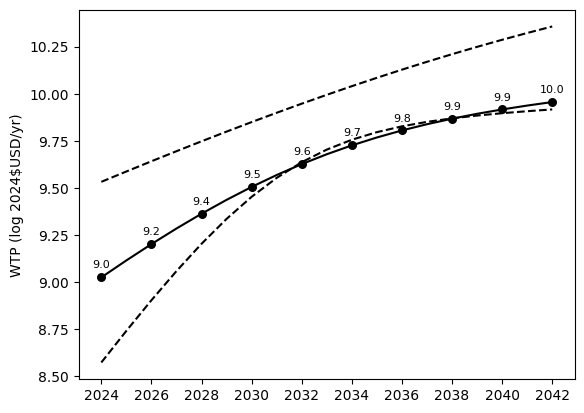



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2024 - logFLOP needed for TAI 32.1 (~125.9 nonillion) 80% CI 27.0 (~1.0 octillion) - 38.6 (~398.1 thousand decillion)
Year: 2025 - logFLOP needed for TAI 31.8 (~63.6 nonillion) 80% CI 26.7 (~534.1 septillion) - 38.4 (~243.7 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.5 (~32.1 nonillion) 80% CI 26.5 (~284.7 septillion) - 38.2 (~149.2 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.2 (~16.5 nonillion) 80% CI 26.2 (~154.0 septillion) - 38.0 (~91.3 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.9 (~8.8 nonillion) 80% CI 25.9 (~85.5 septillion) - 37.7 (~55.9 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.7 (~5.0 nonillion) 80% CI 25.7 (~49.6 septillion) - 37.5 (~34.2 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.5 (~3.1 nonillion) 80% CI 25.5 (~30.7 septillion) - 37.3 (~21.0 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.3 (~2.2 nonillion) 80% 

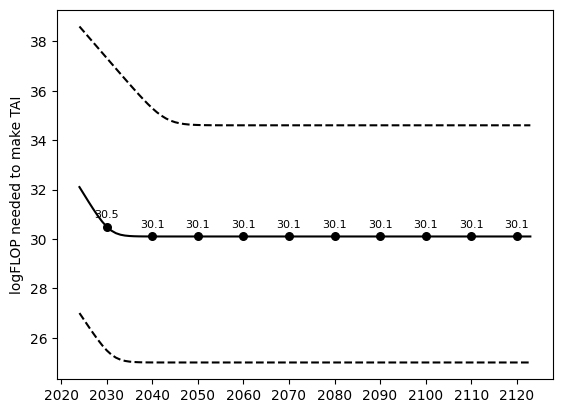

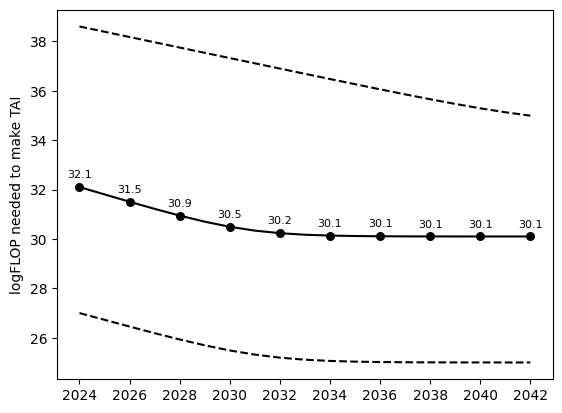



## FLOP per Dollar (Given Declining Costs) ##
Year: 2024 - logFLOP per 2024$1USD 18.7 (~5.4 quintillion) 80% CI 18.4 (~2.3 quintillion) - 19.1 (~14.1 quintillion)
Year: 2025 - logFLOP per 2024$1USD 18.9 (~7.2 quintillion) 80% CI 18.5 (~3.2 quintillion) - 19.3 (~18.2 quintillion)
Year: 2026 - logFLOP per 2024$1USD 19.0 (~9.5 quintillion) 80% CI 18.6 (~4.3 quintillion) - 19.4 (~23.4 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.1 (~12.5 quintillion) 80% CI 18.8 (~5.9 quintillion) - 19.5 (~30.2 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.2 (~16.5 quintillion) 80% CI 18.9 (~8.0 quintillion) - 19.6 (~38.9 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~21.8 quintillion) 80% CI 19.0 (~11.0 quintillion) - 19.7 (~50.1 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.5 (~28.8 quintillion) 80% CI 19.2 (~15.0 quintillion) - 19.8 (~64.5 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.6 (~38.1 quintillion) 80% CI 19.3 (~20.5 quintillion) - 19.9 (~83.1 quintillion)
Year: 20

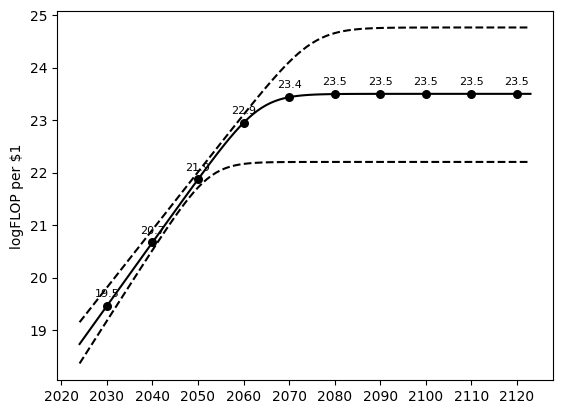

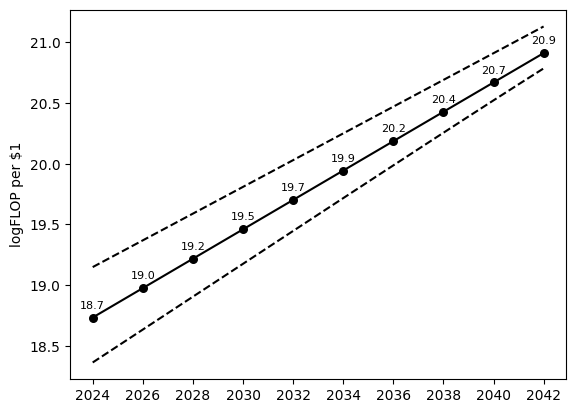



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

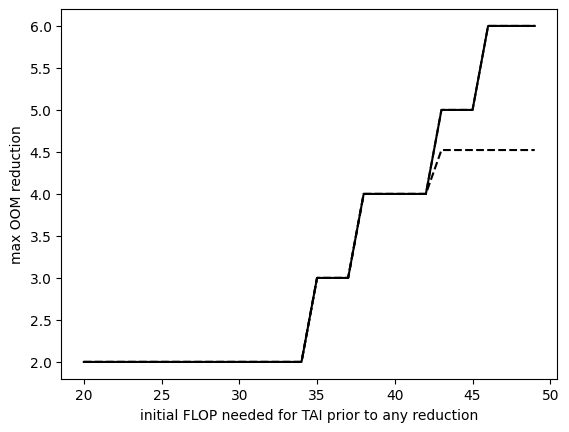



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 21 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 22 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 23 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 24 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 25 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 26 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 27 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 28 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 29 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 30 -> algo doubling rate 1.53yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 31 -> algo doubling rate 1.03yrs (80% CI: 1.68 to 1.68)
TAI log FLOP 32 -> algo doubling rate 0.99yrs (80% CI: 1.18 to 1.18)
TAI log FLOP 33 -> algo doubling rate 0.99yrs (80%

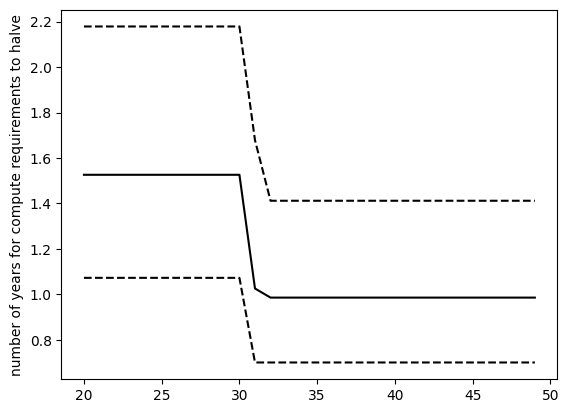



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2024 - 13.4 log 2024$USD to buy TAI (~23.2 trillion) 80% CI 8.6 (~433.0 million) - 19.5 (~28.2 quintillion)
Year: 2025 - 12.9 log 2024$USD to buy TAI (~8.9 trillion) 80% CI 8.2 (~169.3 million) - 19.1 (~13.4 quintillion)
Year: 2026 - 12.5 log 2024$USD to buy TAI (~3.4 trillion) 80% CI 7.8 (~66.1 million) - 18.8 (~6.4 quintillion)
Year: 2027 - 12.1 log 2024$USD to buy TAI (~1.3 trillion) 80% CI 7.4 (~26.2 million) - 18.5 (~3.0 quintillion)
Year: 2028 - 11.7 log 2024$USD to buy TAI (~534.3 billion) 80% CI 7.0 (~10.6 million) - 18.2 (~1.4 quintillion)
Year: 2029 - 11.4 log 2024$USD to buy TAI (~229.4 billion) 80% CI 6.7 (~4.5 million) - 17.8 (~683.8 quadrillion)
Year: 2030 - 11.0 log 2024$USD to buy TAI (~108.0 billion) 80% CI 6.3 (~2.0 million) - 17.5 (~325.1 quadrillion)
Year: 2031 - 10.8 log 2024$USD to buy TAI (~57.1 billion) 80% CI 6.0 (~1.0 million) - 17.2 (~154.6 quadrillion)
Year: 203

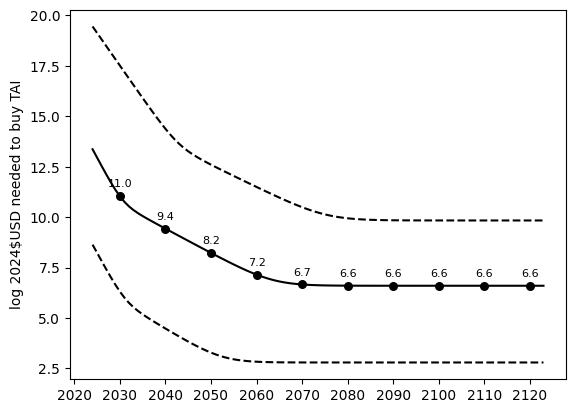

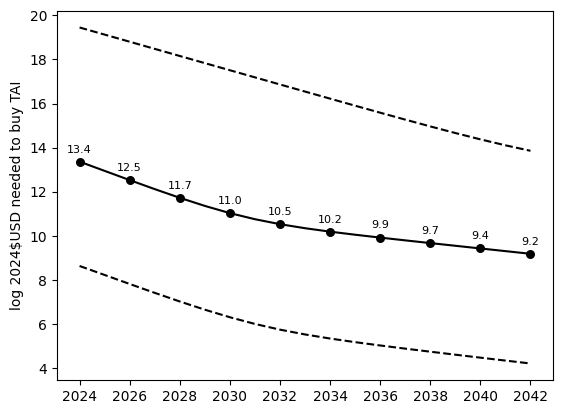



## Actual FLOP at Max Spend ##
Year: 2024 - max log FLOP 27.8 (~5.7 octillion) 80% CI 26.9 (~864.5 septillion) - 28.7 (~48.0 octillion)
Year: 2025 - max log FLOP 28.0 (~9.3 octillion) 80% CI 27.2 (~1.7 octillion) - 28.8 (~70.2 octillion)
Year: 2026 - max log FLOP 28.2 (~15.1 octillion) 80% CI 27.5 (~3.5 octillion) - 29.0 (~102.5 octillion)
Year: 2027 - max log FLOP 28.4 (~24.1 octillion) 80% CI 27.8 (~6.7 octillion) - 29.2 (~149.4 octillion)
Year: 2028 - max log FLOP 28.6 (~38.1 octillion) 80% CI 28.1 (~12.8 octillion) - 29.3 (~217.2 octillion)
Year: 2029 - max log FLOP 28.8 (~59.6 octillion) 80% CI 28.4 (~23.8 octillion) - 29.5 (~315.2 octillion)
Year: 2030 - max log FLOP 29.0 (~92.3 octillion) 80% CI 28.6 (~42.5 octillion) - 29.7 (~456.2 octillion)
Year: 2031 - max log FLOP 29.1 (~141.1 octillion) 80% CI 28.9 (~73.2 octillion) - 29.8 (~658.7 octillion)
Year: 2032 - max log FLOP 29.3 (~213.0 octillion) 80% CI 29.1 (~121.1 octillion) - 30.0 (~948.5 octillion)
Year: 2033 - max log FLO

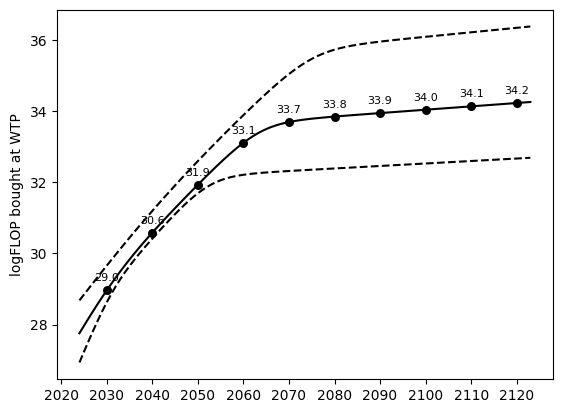

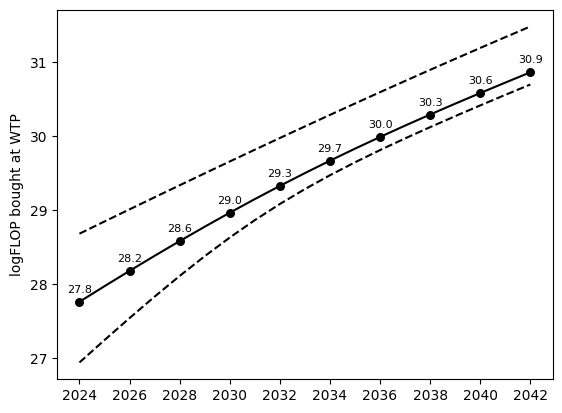



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2024 - max log effective 2024-FLOP 27.8 (~5.7 octillion) 80% CI 26.9 (~864.5 septillion) - 28.7 (~48.0 octillion)
Year: 2025 - max log effective 2024-FLOP 28.3 (~18.5 octillion) 80% CI 27.4 (~2.8 octillion) - 29.3 (~188.8 octillion)
Year: 2026 - max log effective 2024-FLOP 28.8 (~59.0 octillion) 80% CI 28.0 (~9.0 octillion) - 29.9 (~740.6 octillion)
Year: 2027 - max log effective 2024-FLOP 29.3 (~183.1 octillion) 80% CI 28.4 (~28.1 octillion) - 30.5 (~2.9 nonillion)
Year: 2028 - max log effective 2024-FLOP 29.7 (~543.4 octillion) 80% CI 28.9 (~85.4 octillion) - 31.1 (~11.3 nonillion)
Year: 2029 - max log effective 2024-FLOP 30.2 (~1.5 nonillion) 80% CI 29.4 (~248.0 octillion) - 31.6 (~43.7 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.6 (~3.7 nonillion) 80% CI 29.8 (~679.8 octillion) - 32.2 (~166.1 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.9 (~8.2 nonillion) 80% CI 30

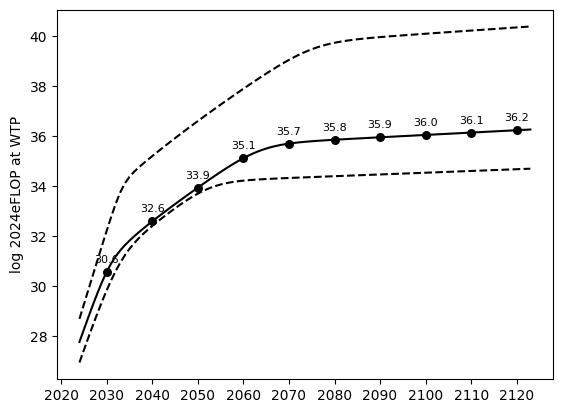

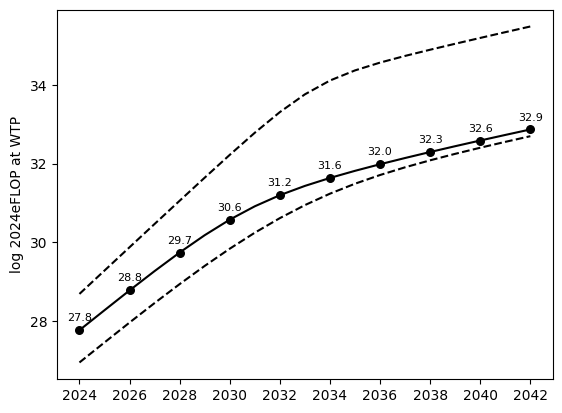


## TAI FLOP SIZE ##
{1: 24.1,
 5: 25.395,
 10: 26.2,
 20: 27.0,
 30: 28.3,
 40: 30.2,
 50: 32.1,
 60: 34.04,
 70: 36.1,
 80: 38.6,
 90: 42.2,
 95: 45.205,
 99: 49.300999999999995}


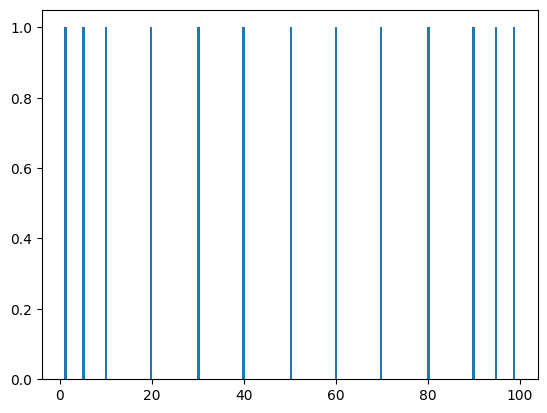



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.0640845106854706,
 5: 3.147324429891958,
 10: 3.8262074076456885,
 20: 4.522438563674546,
 30: 5.280454373764594,
 40: 6.0618021530407775,
 50: 6.869421699411989,
 60: 7.646175805556829,
 70: 8.785742826386825,
 80: 10.154692135890063,
 90: 13.384168994158205,
 95: 15.719973237800048,
 99: 21.596534718228515}


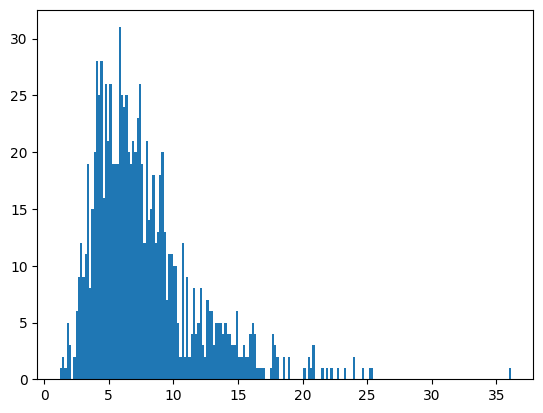



## MIN ALGO DOUBLING RATE ##
{1: 0.35939672301851305,
 5: 0.5024613006590344,
 10: 0.5794570814341263,
 20: 0.7008282595573205,
 30: 0.8041296955519172,
 40: 0.8950370998017508,
 50: 0.9861037527971084,
 60: 1.0969204037781732,
 70: 1.2578977021467286,
 80: 1.4119766276149641,
 90: 1.6404440827172924,
 95: 1.8986839021258284,
 99: 2.413382904683778}


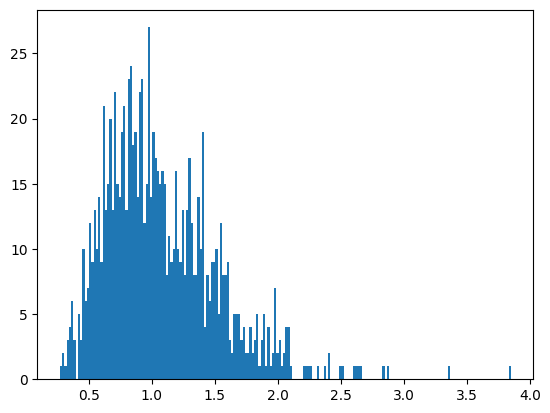



## MAX ALGO DOUBLING RATE ##
{1: 0.5695627761323651,
 5: 0.7433404914799476,
 10: 0.8857073514088896,
 20: 1.0730003325536983,
 30: 1.2240193594325466,
 40: 1.363140482037556,
 50: 1.5261474771562438,
 60: 1.7009621172255758,
 70: 1.8996155088785955,
 80: 2.1783428339310436,
 90: 2.6052347415173664,
 95: 3.0030289288765184,
 99: 3.8711407067376955}


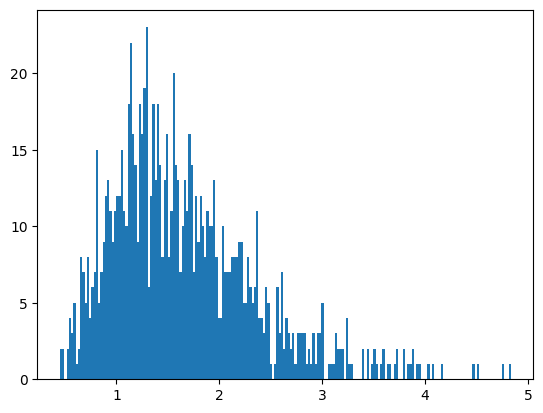



## INITIAL FLOP PER DOLLAR ##
{1: 17.701837486724056,
 5: 18.023284327025248,
 10: 18.139293973770165,
 20: 18.363620058237792,
 30: 18.485618339682922,
 40: 18.62250764514635,
 50: 18.733830362963104,
 60: 18.85174156006586,
 70: 18.98986138008221,
 80: 19.14910795133498,
 90: 19.357426959882602,
 95: 19.479677842125994,
 99: 19.843352449802}


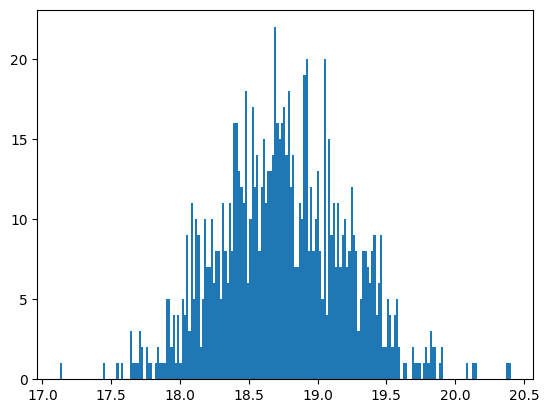



## FLOP HALVING RATE ##
{1: 1.7791556258972399,
 5: 1.9859428260399383,
 10: 2.086401320875167,
 20: 2.222052365058958,
 30: 2.325975780094094,
 40: 2.4166723915907333,
 50: 2.487249859511521,
 60: 2.5615831148138373,
 70: 2.653789755681269,
 80: 2.7343812581807265,
 90: 2.831336979078501,
 95: 2.945591975756024,
 99: 3.223289710227636}


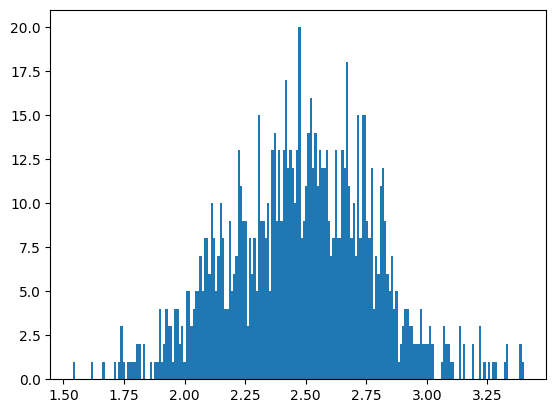



## MAX FLOP PER DOLLAR ##
{1: 20.087462715310075,
 5: 20.964949091658834,
 10: 21.537358067069096,
 20: 22.202778143819174,
 30: 22.665628768755415,
 40: 23.090161869244923,
 50: 23.499716279553205,
 60: 23.89979932343663,
 70: 24.29013063165274,
 80: 24.763952295400433,
 90: 25.353440121284,
 95: 26.013877065331283,
 99: 27.225171758619698}


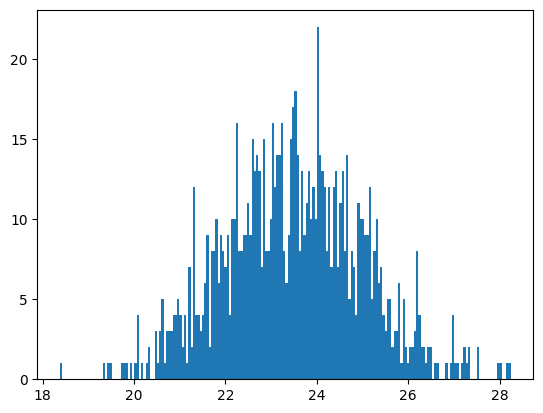



## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.4,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 9.1,
 60: 9.2,
 70: 9.4,
 80: 9.6,
 90: 9.8,
 95: 10.1,
 99: 10.5}


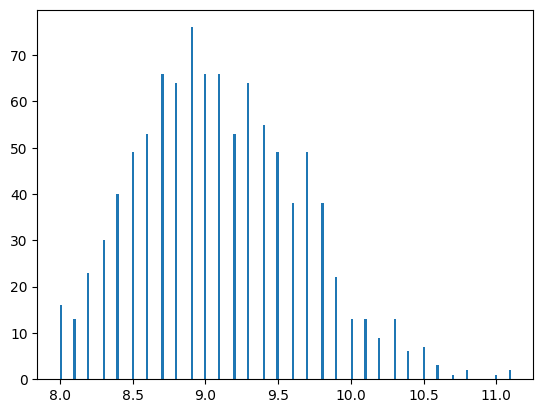



## INITIAL GDP ##
{1: 24826662170974.24,
 5: 24907744951240.742,
 10: 24948544809992.64,
 20: 25012765795201.46,
 30: 25051327801495.91,
 40: 25083660047394.508,
 50: 25118663328354.01,
 60: 25153604902487.105,
 70: 25183287558402.26,
 80: 25227045856783.89,
 90: 25286462811332.508,
 95: 25330134441523.457,
 99: 25400142883023.53}


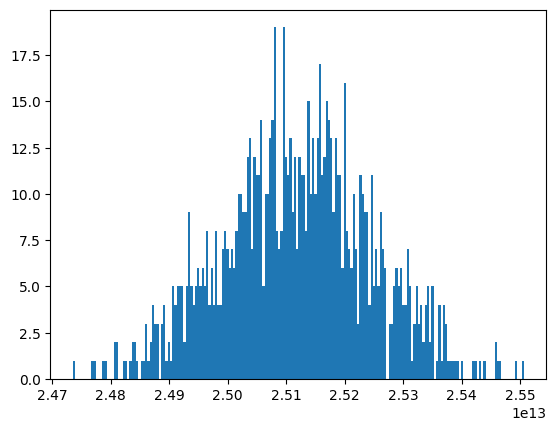



## GDP GROWTH ##
{1: 1.0051371935854831,
 5: 1.009665239290039,
 10: 1.0124585812029903,
 20: 1.01621296436876,
 30: 1.0185807804205642,
 40: 1.0203313104068543,
 50: 1.021947651234223,
 60: 1.0239929959358443,
 70: 1.0265506301800817,
 80: 1.0293609500176806,
 90: 1.0320808838841542,
 95: 1.0351064420830587,
 99: 1.040828298097617}


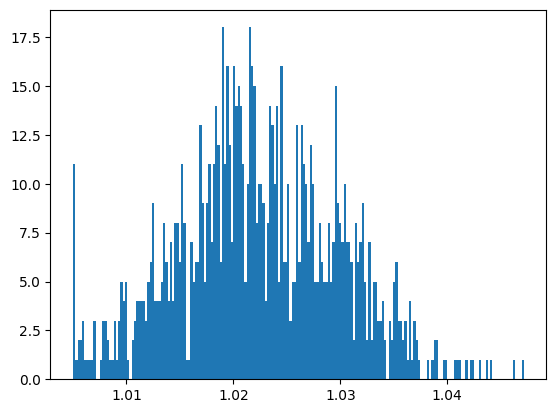



## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.0002658671272121763,
 60: 0.00037801402948721955,
 70: 0.0005569439664038399,
 80: 0.000934933300290226,
 90: 0.0018317125570351696,
 95: 0.0025996137866616275,
 99: 0.0063121157755489255}


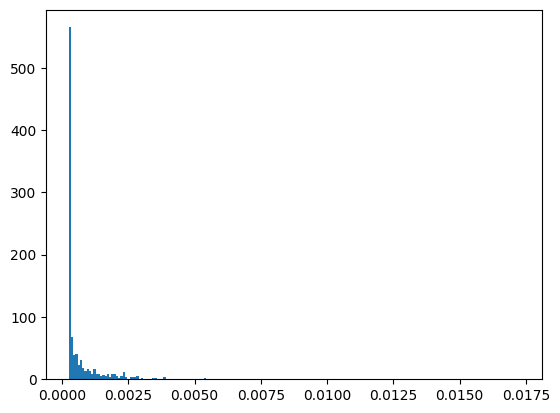



## SPEND DOUBLING TIME ##
{1: 0.9,
 5: 1.0151251965585952,
 10: 1.231680376223508,
 20: 1.66730014419876,
 30: 2.01889107726404,
 40: 2.4414058216354095,
 50: 2.811624991707008,
 60: 3.3759084160003034,
 70: 3.863326396248608,
 80: 4.808568936323292,
 90: 6.455153454227214,
 95: 8.474023967765715,
 99: 12.396813028655654}


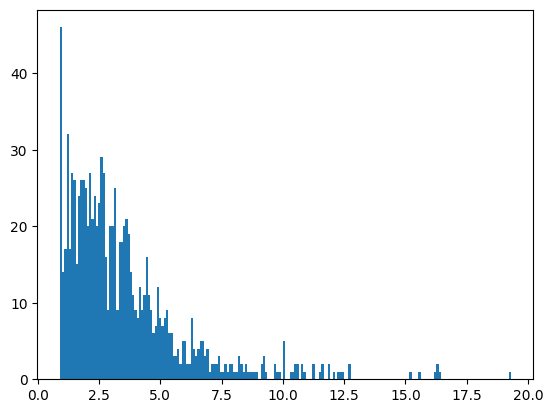





## Nonscaling delay ##
There are 7 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 2,
 30: 3,
 40: 3,
 50: 3,
 60: 3,
 70: 4,
 80: 4,
 90: 5,
 95: 6,
 99: 12}
## Chance of nonscaling delay ##


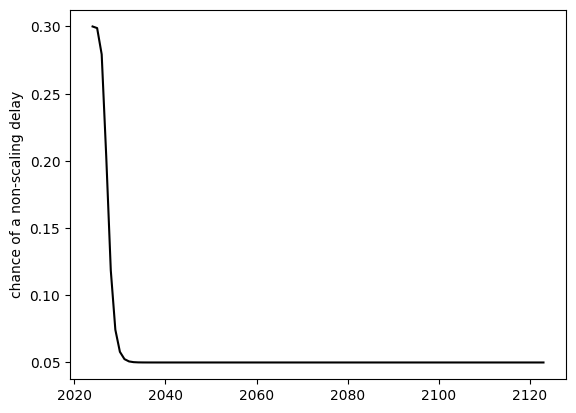

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - ch

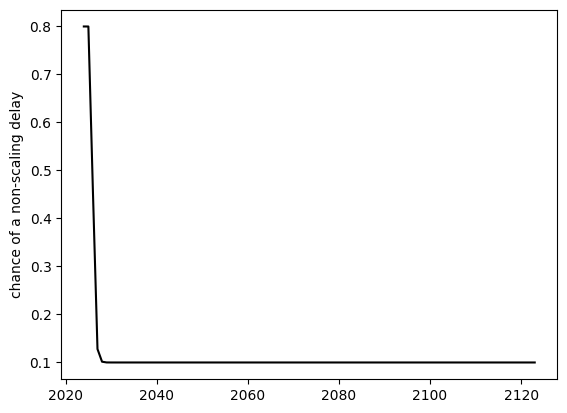

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034

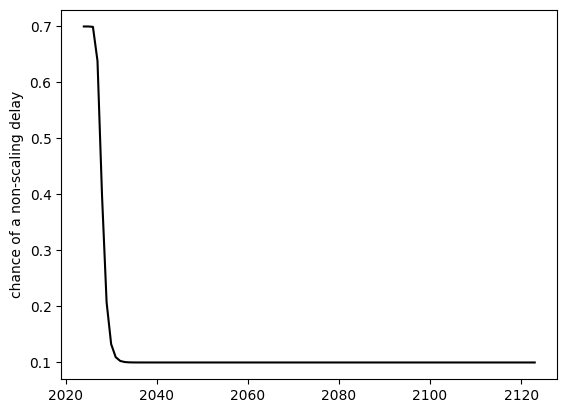

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034

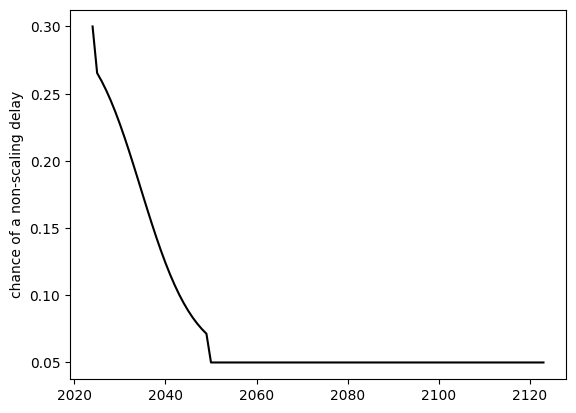

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2034

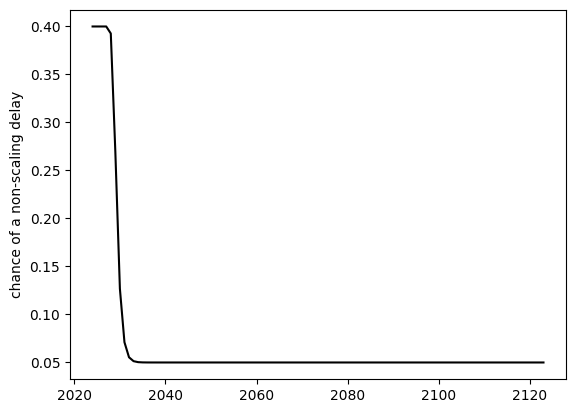

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - 

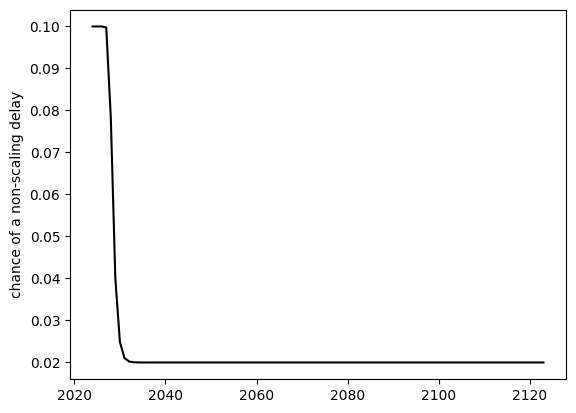

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 4%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - cha

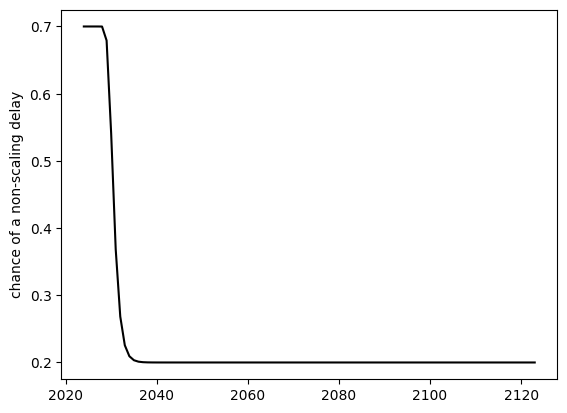

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2034

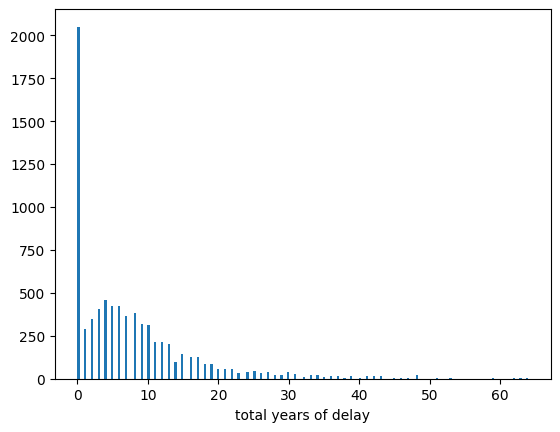

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 35.9 log FLOP (~794.3 decillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2024$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~81.5 sextillion) per 2024$USD.
* We are initially willing to pay 9.0 log 2024$USD (~920.1 million).
* This doubles every 3.5 year to a max of 0.045775% of GDP (initially ~11.5 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 35.9 logFLOP which costs 17.4 log 2024$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 35.8 logFLOP which costs 17.1 log 2024$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.8 2024-log-eFLOP)
2026 - TAI takes 35.7 logFLOP which costs 16.9 log 2024$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.1 2024-log-eFLOP)
2027 - TAI takes 35.6 logFLOP which cost

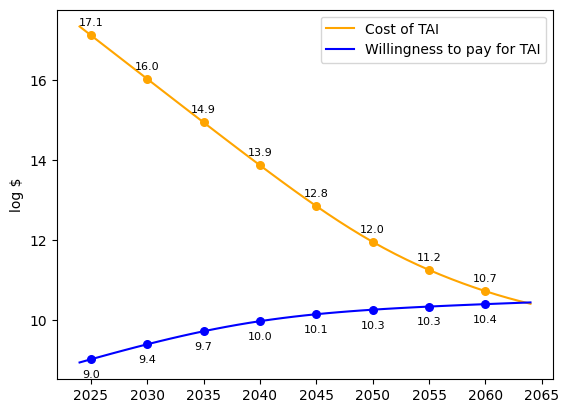

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 24.5 log FLOP (~3.2 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~23.9 quintillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~775.4 million).
* This doubles every 1.9 year to a max of 0.129179% of GDP (initially ~32.5 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 24.5 logFLOP which costs 5.1 log 2024$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.3 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years

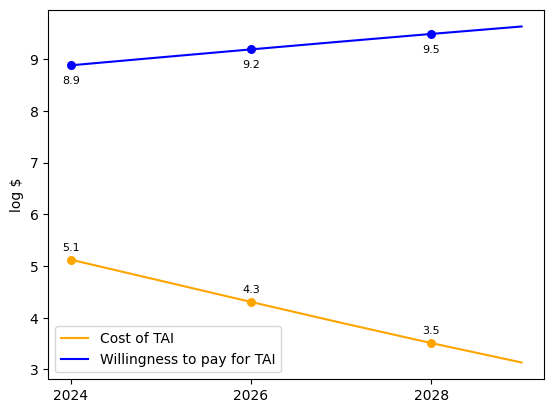

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 33.8 log FLOP (~6.3 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~884.3 million).
* This doubles every 2.1 year to a max of 0.030434% of GDP (initially ~7.6 billion 2024$USD).
* GDP grows at a rate of 1.026x per year.
---
2024 - TAI takes 33.8 logFLOP which costs 15.7 log 2024$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.0 2024-log-eFLOP)
2025 - TAI takes 33.6 logFLOP which costs 15.4 log 2024$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.5 2024-log-eFLOP)
2026 - TAI takes 33.4 logFLOP which costs 15.0 log 2024$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.9 2024-log-eFLOP)
2027 - TAI takes 33.2 logFLOP which costs 14

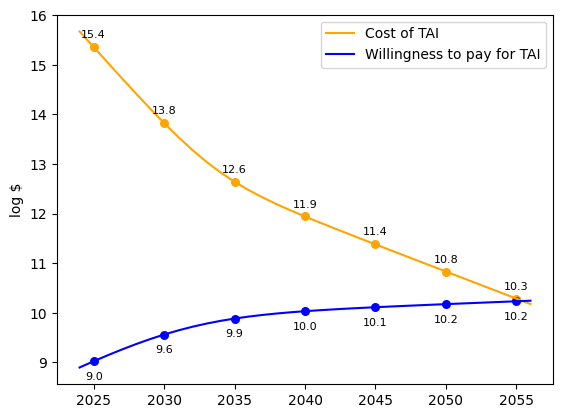

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 25.6 log FLOP (~39.8 septillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10.7 septillion) per 2024$USD.
* We are initially willing to pay 9.2 log 2024$USD (~1.5 billion).
* This doubles every 3.2 year to a max of 0.025% of GDP (initially ~6.2 billion 2024$USD).
* GDP grows at a rate of 1.019x per year.
---
2024 - TAI takes 25.6 logFLOP which costs 7.0 log 2024$USD to buy vs. WTP at 9.1 (buys 27.6 log FLOP or 27.6 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- 

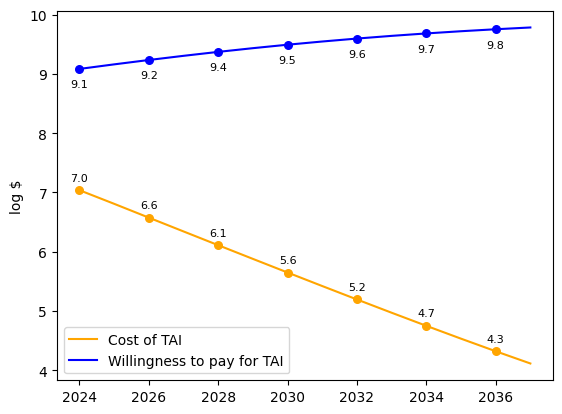

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.6 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~129.2 septillion) per 2024$USD.
* We are initially willing to pay 9.1 log 2024$USD (~1.2 billion).
* This doubles every 4.4 year to a max of 0.209565% of GDP (initially ~53.0 billion 2024$USD).
* GDP grows at a rate of 1.037x per year.
---
2024 - TAI takes 27.2 logFLOP which costs 8.1 log 2024$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.2 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Non

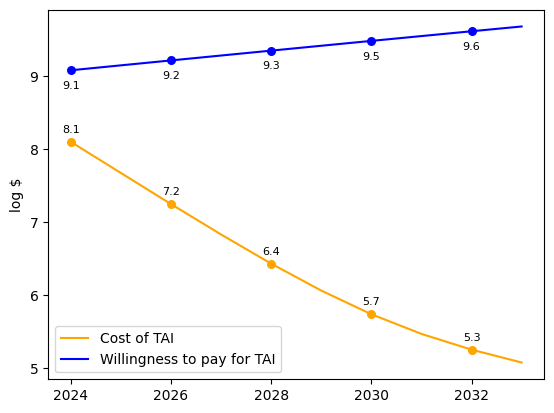

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 31.7 log FLOP (~50.1 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.9 quintillion) per 2024$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~228.4 septillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~719.7 million).
* This doubles every 1.6 year to a max of 0.030722% of GDP (initially ~7.7 billion 2024$USD).
* GDP grows at a rate of 1.013x per year.
---
2024 - TAI takes 31.7 logFLOP which costs 12.8 log 2024$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2024-log-eFLOP)
2025 - TAI takes 31.5 logFLOP which costs 12.5 log 2024$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.2 2024-log-eFLOP)
2026 - TAI takes 31.3 logFLOP which costs 12.2 log 2024$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.7 2024-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs

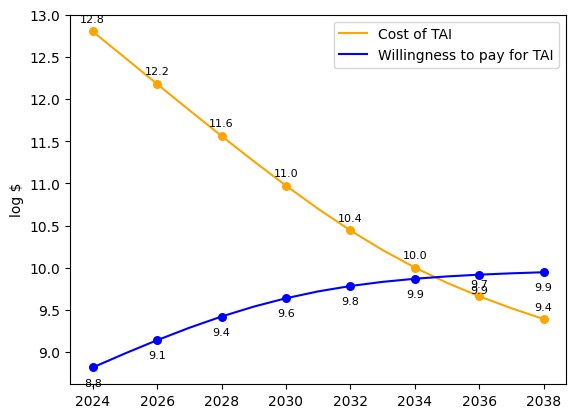

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.5 sextillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~1.8 billion).
* This doubles every 4.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.017x per year.
---
2024 - TAI takes 27.7 logFLOP which costs 9.0 log 2024$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscalin

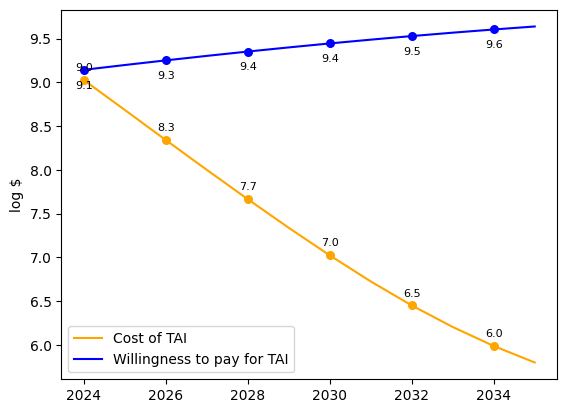

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 30.3 log FLOP (~2.0 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~729.3 quadrillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~331.3 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~572.8 million).
* This doubles every 4.3 year to a max of 0.025% of GDP (initially ~6.2 billion 2024$USD).
* GDP grows at a rate of 1.018x per year.
---
2024 - TAI takes 30.3 logFLOP which costs 12.4 log 2024$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.6 2024-log-eFLOP)
2025 - TAI takes 30.1 logFLOP which costs 12.2 log 2024$USD to buy vs. WTP at 8.8 (buys 26.7 log FLOP or 26.9 2024-log-eFLOP)
2026 - TAI takes 30.0 logFLOP which costs 11.9 log 2024$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 27.2 2024-log-eFLOP)
2027 - TAI takes 29.8 logFLOP which costs 

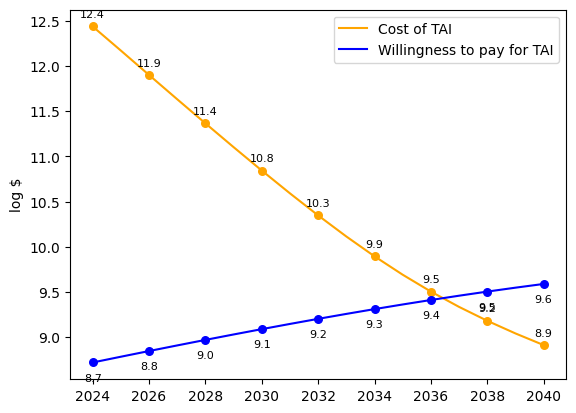

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~976.8 quadrillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8.7 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~705.5 million).
* This doubles every 13.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.014x per year.
---
2024 - TAI takes 27.6 logFLOP which costs 9.6 log 2024$USD to buy vs. WTP at 8.8 (buys 26.8 log FLOP or 26.8 2024-log-eFLOP)
2025 - TAI takes 27.4 logFLOP which costs 9.3 log 2024$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 27.1 2024-log-eFLOP)
2026 - TAI takes 27.2 logFLOP which costs 9.0 log 2024$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.5 2024-log-eFLOP)
2027 - TAI takes 27.0 logFLOP which costs 8.7 

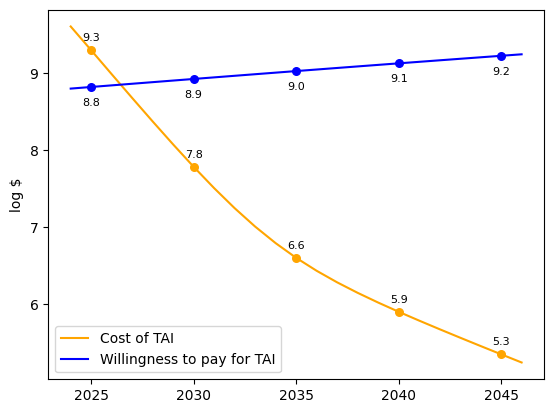

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.2 quintillion) per 2024$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~158.8 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~603.6 million).
* This doubles every 2.0 year to a max of 0.055825% of GDP (initially ~13.9 billion 2024$USD).
* GDP grows at a rate of 1.013x per year.
---
2024 - TAI takes 34.7 logFLOP which costs 15.6 log 2024$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 27.9 2024-log-eFLOP)
2025 - TAI takes 34.5 logFLOP which costs 15.3 log 2024$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.3 2024-log-eFLOP)
2026 - TAI takes 34.4 logFLOP which costs 14.9 log 2024$USD to buy vs. WTP at 9.0 (buys 28.5 log FLOP or 28.8 2024-log-eFLOP)
2027 - TAI takes 34.2 logFLOP which co

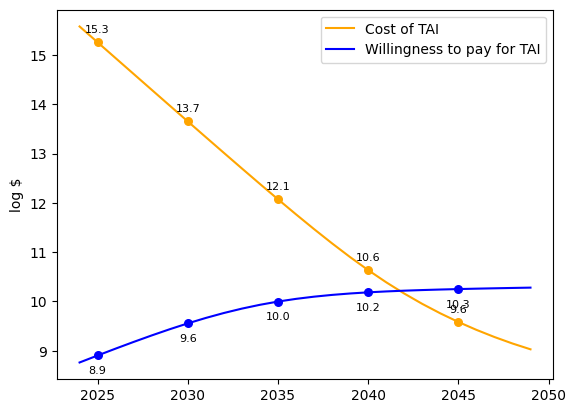

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.6 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19.3 sextillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~884.7 million).
* This doubles every 1.4 year to a max of 0.030976% of GDP (initially ~7.7 billion 2024$USD).
* GDP grows at a rate of 1.026x per year.
---
2024 - TAI takes 26.2 logFLOP which costs 7.3 log 2024$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 yea

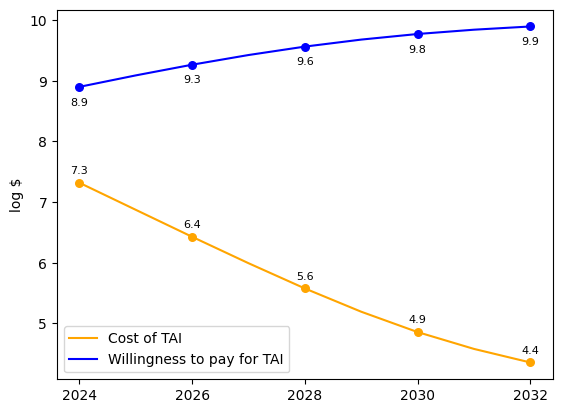

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 40.8 log FLOP (~63.1 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3.8 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.4 quintillion) per 2024$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~7.0 septillion) per 2024$USD.
* We are initially willing to pay 9.0 log 2024$USD (~1.0 billion).
* This doubles every 2.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.024x per year.
---
2024 - TAI takes 40.8 logFLOP which costs 22.3 log 2024$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 40.6 logFLOP which costs 21.9 log 2024$USD to buy vs. WTP at 9.1 (buys 27.7 log FLOP or 28.0 2024-log-eFLOP)
2026 - TAI takes 40.4 logFLOP which costs 21.6 log 2024$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.4 2024-log-eFLOP)
2027 - TAI takes 40.2 logFLOP which c

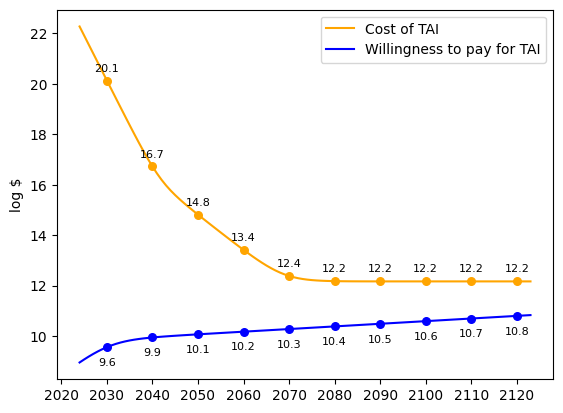

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 42.5 log FLOP (~3.2 billion decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 26.6 log FLOP (~404.3 septillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~315.2 million).
* This doubles every 2.3 year to a max of 0.385006% of GDP (initially ~96.7 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 42.5 logFLOP which costs 23.8 log 2024$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2024-log-eFLOP)
2025 - TAI takes 42.3 logFLOP which costs 23.5 log 2024$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.6 2024-log-eFLOP)
2026 - TAI takes 42.1 logFLOP which costs 23.2 log 2024$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 28.0 2024-log-eFLOP)
2027 - TAI takes 41.9 logFLOP wh

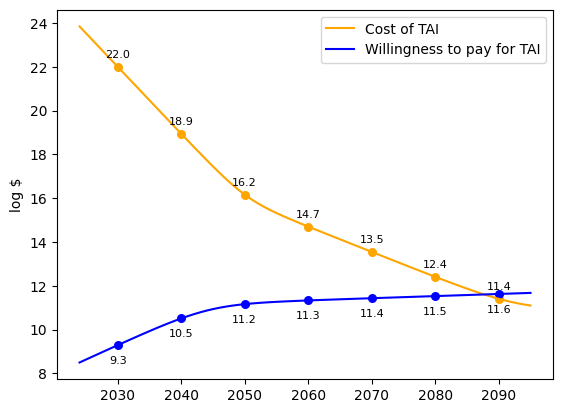

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 45.7 log FLOP (~5.0 trillion decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~603.9 sextillion) per 2024$USD.
* We are initially willing to pay 8.3 log 2024$USD (~196.0 million).
* This doubles every 2.5 year to a max of 0.04505% of GDP (initially ~11.2 billion 2024$USD).
* GDP grows at a rate of 1.013x per year.
---
2024 - TAI takes 45.7 logFLOP which costs 27.4 log 2024$USD to buy vs. WTP at 8.3 (buys 26.6 log FLOP or 26.6 2024-log-eFLOP)
2025 - TAI takes 45.6 logFLOP which costs 27.1 log 2024$USD to buy vs. WTP at 8.4 (buys 26.9 log FLOP or 27.0 2024-log-eFLOP)
2026 - TAI takes 45.4 logFLOP which costs 26.8 log 2024$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.4 2024-log-eFLOP)
2027 - TAI takes 45.3 logFLOP wh

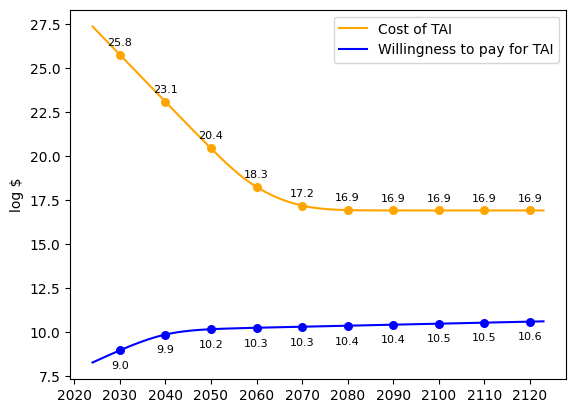

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 29.0 log FLOP (~100.0 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.3 septillion) per 2024$USD.
* We are initially willing to pay 9.6 log 2024$USD (~4.2 billion).
* This doubles every 2.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.036x per year.
---
2024 - TAI takes 29.0 logFLOP which costs 10.7 log 2024$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 27.7 2024-log-eFLOP)
2025 - TAI takes 28.7 logFLOP which costs 10.3 log 2024$USD to buy vs. WTP at 9.5 (buys 27.9 log FLOP or 28.2 2024-log-eFLOP)
2026 - TAI takes 28.4 logFLOP which costs 9.9 log 2024$USD to buy vs. WTP at 9.5 (buys 28.1 log FLOP or 28.6 2024-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 9.5 l

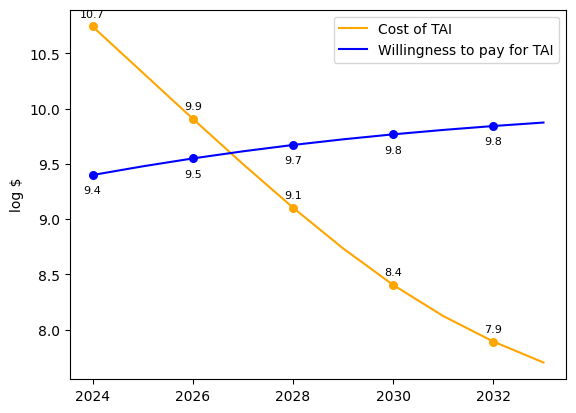

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.7 sextillion) per 2024$USD.
* We are initially willing to pay 8.0 log 2024$USD (~99.1 million).
* This doubles every 2.2 year to a max of 0.042954% of GDP (initially ~10.8 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 26.8 logFLOP which costs 8.3 log 2024$USD to buy vs. WTP at 8.0 (buys 26.5 log FLOP or 26.5 2024-log-eFLOP)
2025 - TAI takes 26.7 logFLOP which costs 8.0 log 2024$USD to buy vs. WTP at 8.1 (buys 26.8 log FLOP or 26.9 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling 

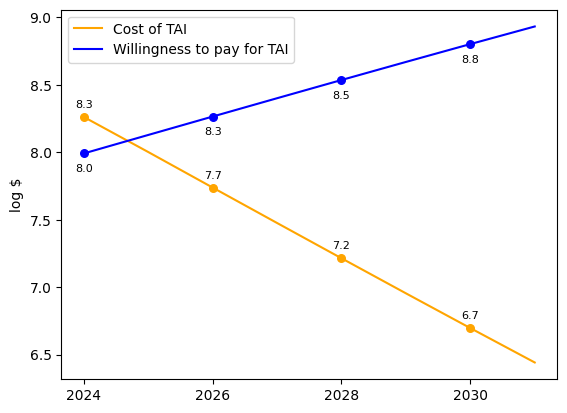

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 32.9 log FLOP (~794.3 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~31.9 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.6 septillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~1.8 billion).
* This doubles every 3.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 32.9 logFLOP which costs 13.4 log 2024$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 28.6 2024-log-eFLOP)
2025 - TAI takes 32.7 logFLOP which costs 13.0 log 2024$USD to buy vs. WTP at 9.2 (buys 28.8 log FLOP or 29.1 2024-log-eFLOP)
2026 - TAI takes 32.4 logFLOP which costs 12.7 log 2024$USD to buy vs. WTP at 9.3 (buys 29.0 log FLOP or 29.5 2024-log-eFLOP)
2027 - TAI takes 32.2 logFLOP which costs 12.

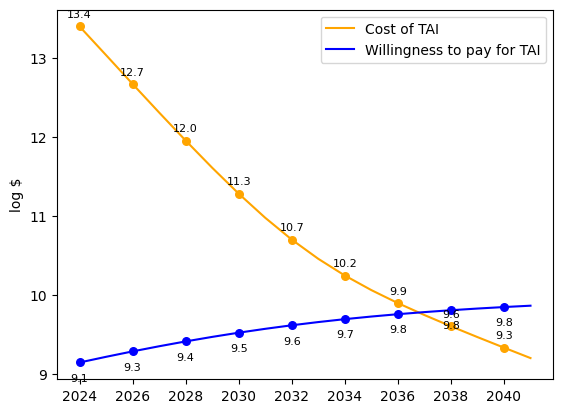

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 39.9 log FLOP (~7.9 million decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.8 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~15.7 septillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~783.2 million).
* This doubles every 0.9 year to a max of 0.22239% of GDP (initially ~56.0 billion 2024$USD).
* GDP grows at a rate of 1.024x per year.
---
2024 - TAI takes 39.9 logFLOP which costs 21.3 log 2024$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 39.3 logFLOP which costs 20.6 log 2024$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 38.7 logFLOP which costs 19.9 log 2024$USD to buy vs. WTP at 9.5 (buys 28.3 log FLOP or 29.6 2024-log-eFLOP)
2027 - TAI takes 38.0 logFLOP whic

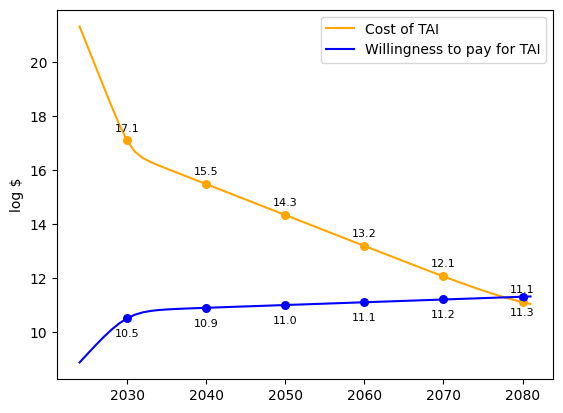

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 29.6 log FLOP (~398.1 octillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.1 septillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~377.7 million).
* This doubles every 2.0 year to a max of 0.029508% of GDP (initially ~7.4 billion 2024$USD).
* GDP grows at a rate of 1.037x per year.
---
2024 - TAI takes 29.6 logFLOP which costs 10.8 log 2024$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 29.5 logFLOP which costs 10.5 log 2024$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 27.8 2024-log-eFLOP)
2026 - TAI takes 29.3 logFLOP which costs 10.2 log 2024$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.2 2024-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs

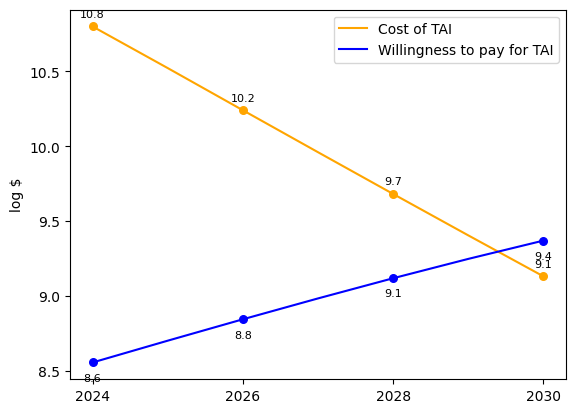

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 50.6 log FLOP (~398.1 quadrillion decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3.0 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.2 quintillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12.1 septillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~628.1 million).
* This doubles every 6.7 year to a max of 0.544388% of GDP (initially ~136.5 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 50.6 logFLOP which costs 31.6 log 2024$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 50.4 logFLOP which costs 31.3 log 2024$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.1 2024-log-eFLOP)
2026 - TAI takes 50.2 logFLOP which costs 31.0 log 2024$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.5 2024-log-eFLOP)
2027 - TAI takes 50.0 lo

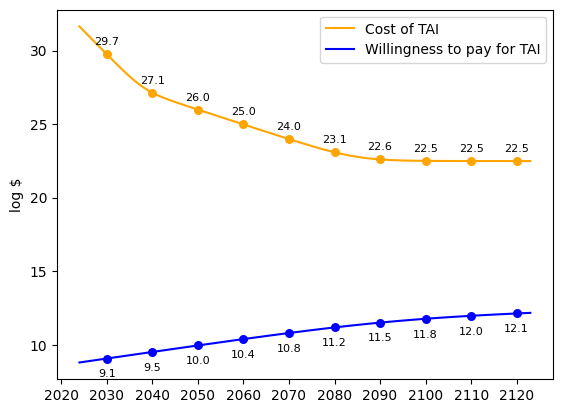

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~19.4 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~153.4 sextillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.4 billion).
* This doubles every 8.2 year to a max of 0.19352% of GDP (initially ~48.5 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 26.5 logFLOP which costs 7.2 log 2024$USD to buy vs. WTP at 9.4 (buys 28.6 log FLOP or 28.6 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 yea

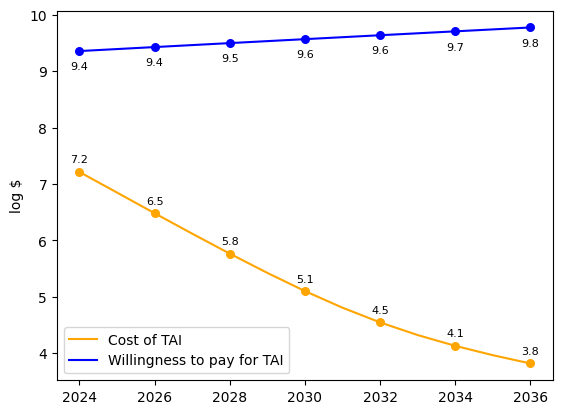

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 35.4 log FLOP (~251.2 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~546.9 quadrillion) per 2024$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.7 septillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~3.5 billion).
* This doubles every 1.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 35.4 logFLOP which costs 17.7 log 2024$USD to buy vs. WTP at 9.4 (buys 27.1 log FLOP or 27.1 2024-log-eFLOP)
2025 - TAI takes 35.1 logFLOP which costs 17.3 log 2024$USD to buy vs. WTP at 9.5 (buys 27.3 log FLOP or 27.6 2024-log-eFLOP)
2026 - TAI takes 34.9 logFLOP which costs 17.0 log 2024$USD to buy vs. WTP at 9.6 (buys 27.6 log FLOP or 28.1 2024-log-eFLOP)
2027 - TAI takes 34.6 logFLOP which costs 16

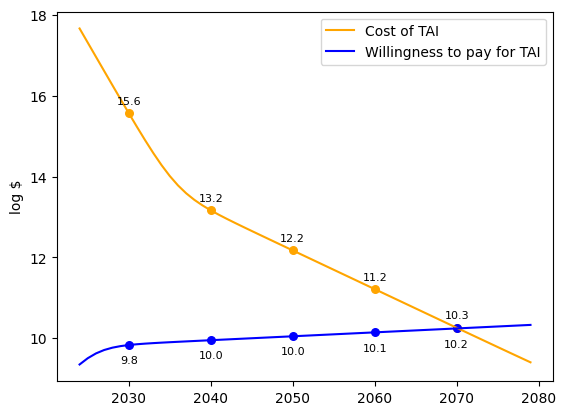

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.6 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~136.9 septillion) per 2024$USD.
* We are initially willing to pay 9.1 log 2024$USD (~1.1 billion).
* This doubles every 3.6 year to a max of 0.045842% of GDP (initially ~11.6 billion 2024$USD).
* GDP grows at a rate of 1.013x per year.
---
2024 - TAI takes 29.5 logFLOP which costs 10.2 log 2024$USD to buy vs. WTP at 9.0 (buys 28.3 log FLOP or 28.3 2024-log-eFLOP)
2025 - TAI takes 29.4 logFLOP which costs 10.0 log 2024$USD to buy vs. WTP at 9.1 (buys 28.5 log FLOP or 28.6 2024-log-eFLOP)
2026 - TAI takes 29.3 logFLOP which costs 9.7 log 2024$USD to buy vs. WTP at 9.2 (buys 28.7 log FLOP or 28.9 2024-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which cost

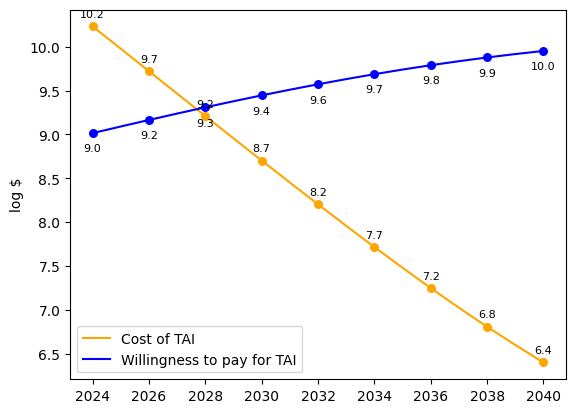

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 28.2 log FLOP (~15.8 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.1 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~704.8 million).
* This doubles every 3.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 28.2 logFLOP which costs 10.2 log 2024$USD to buy vs. WTP at 8.8 (buys 26.8 log FLOP or 26.8 2024-log-eFLOP)
2025 - TAI takes 27.9 logFLOP which costs 9.7 log 2024$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.3 2024-log-eFLOP)
2026 - TAI takes 27.6 logFLOP which costs 9.3 log 2024$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.8 2024-log-eFLOP)
2027 - TAI takes 27.3 logFLOP which costs 8.9 

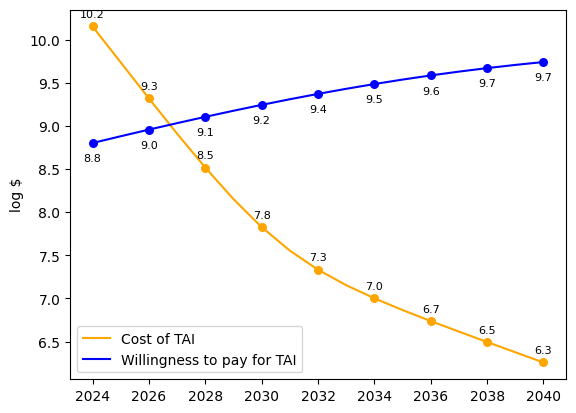

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.1 quintillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.4 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~573.9 million).
* This doubles every 2.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.03x per year.
---
2024 - TAI takes 33.0 logFLOP which costs 14.1 log 2024$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 27.6 2024-log-eFLOP)
2025 - TAI takes 32.9 logFLOP which costs 13.8 log 2024$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.0 2024-log-eFLOP)
2026 - TAI takes 32.7 logFLOP which costs 13.5 log 2024$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.4 2024-log-eFLOP)
2027 - TAI takes 32.6 logFLOP which costs 1

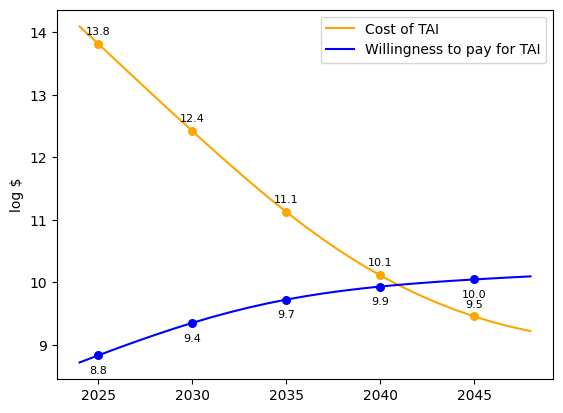

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 27.4 log FLOP (~2.5 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.9 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~376.1 quintillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~882.2 million).
* This doubles every 1.4 year to a max of 0.030028% of GDP (initially ~7.5 billion 2024$USD).
* GDP grows at a rate of 1.008x per year.
---
2024 - TAI takes 27.4 logFLOP which costs 8.5 log 2024$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 11 yea

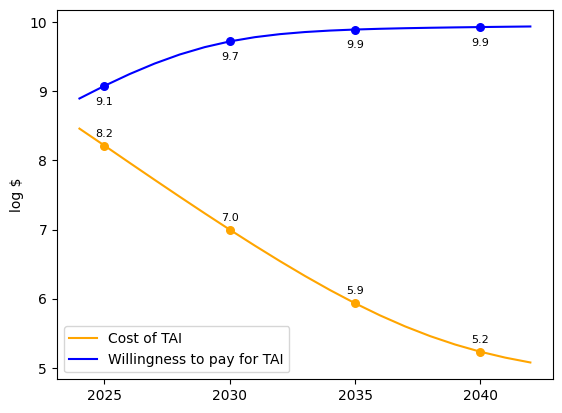

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 31.7 log FLOP (~50.1 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2024$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~155.9 sextillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~374.4 million).
* This doubles every 3.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.026x per year.
---
2024 - TAI takes 31.7 logFLOP which costs 13.1 log 2024$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2024-log-eFLOP)
2025 - TAI takes 31.3 logFLOP which costs 12.5 log 2024$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.8 2024-log-eFLOP)
2026 - TAI takes 30.8 logFLOP which costs 12.0 log 2024$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 28.4 2024-log-eFLOP)
2027 - TAI takes 30.4 logFLOP which costs 1

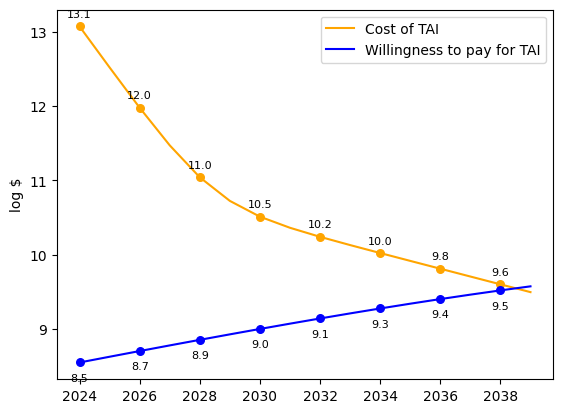

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~65.5 septillion) per 2024$USD.
* We are initially willing to pay 8.7 log 2024$USD (~464.2 million).
* This doubles every 6.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.03x per year.
---
2024 - TAI takes 26.2 logFLOP which costs 7.9 log 2024$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- robotics p_nonscaling_issue p=0.3 -> Nons

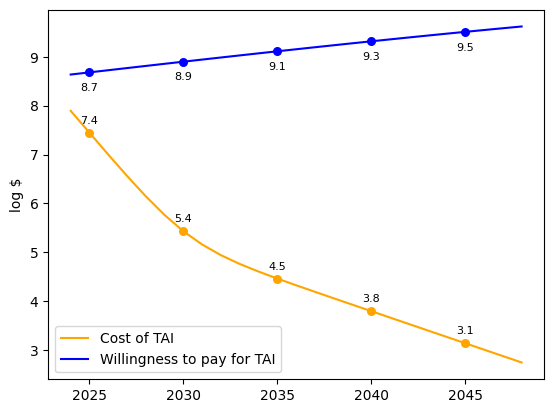

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 25.4 log FLOP (~25.1 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~552.9 sextillion) per 2024$USD.
* We are initially willing to pay 9.8 log 2024$USD (~5.9 billion).
* This doubles every 6.0 year to a max of 0.05796% of GDP (initially ~14.5 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 25.4 logFLOP which costs 7.0 log 2024$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.0 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> No

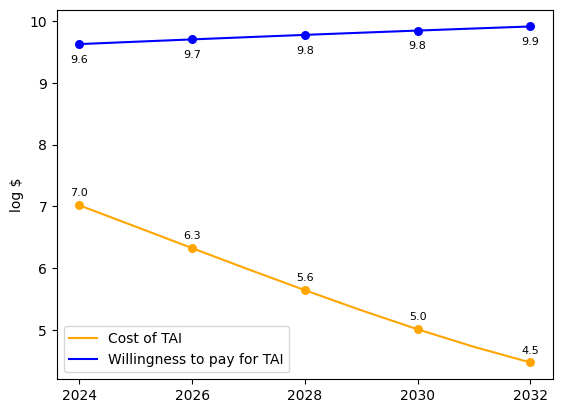

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.1 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35.2 sextillion) per 2024$USD.
* We are initially willing to pay 9.8 log 2024$USD (~6.4 billion).
* This doubles every 3.5 year to a max of 0.071497% of GDP (initially ~17.9 billion 2024$USD).
* GDP grows at a rate of 1.015x per year.
---
2024 - TAI takes 34.7 logFLOP which costs 15.9 log 2024$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 28.5 2024-log-eFLOP)
2025 - TAI takes 34.6 logFLOP which costs 15.7 log 2024$USD to buy vs. WTP at 9.7 (buys 28.6 log FLOP or 28.8 2024-log-eFLOP)
2026 - TAI takes 34.5 logFLOP which costs 15.5 log 2024$USD to buy vs. WTP at 9.8 (buys 28.8 log FLOP or 29.0 2024-log-eFLOP)
2027 - TAI takes 34.4 logFLOP which costs 

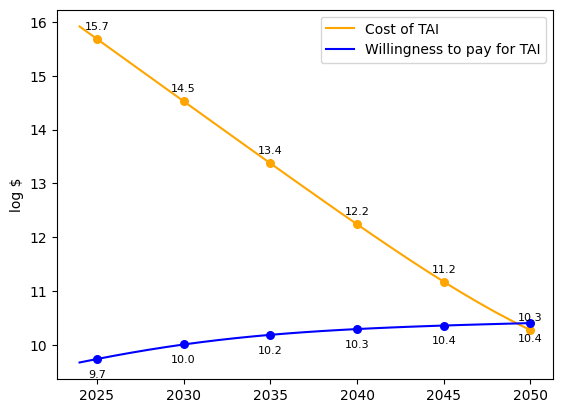

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 19.4 log FLOP (~27.4 quintillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~573.5 million).
* This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 27.1 logFLOP which costs 8.9 log 2024$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.0 2024-log-eFLOP)
2025 - TAI takes 27.0 logFLOP which costs 8.6 log 2024$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.4 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p

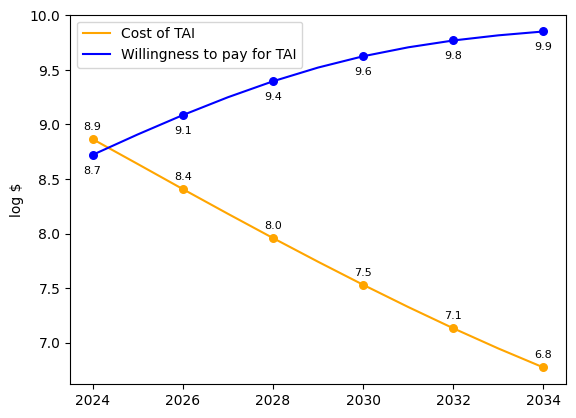

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 3.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~29.9 quintillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 26.9 log FLOP (~842.2 septillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~573.3 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.038x per year.
---
2024 - TAI takes 29.5 logFLOP which costs 10.0 log 2024$USD to buy vs. WTP at 8.7 (buys 28.2 log FLOP or 28.2 2024-log-eFLOP)
2025 - TAI takes 29.4 logFLOP which costs 9.8 log 2024$USD to buy vs. WTP at 8.9 (buys 28.5 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 29.3 logFLOP which costs 9.7 log 2024$USD to buy vs. WTP at 9.0 (buys 28.7 log FLOP or 28.9 2024-log-eFLOP)
2027 - TAI takes 29.3 logFLOP which costs 9

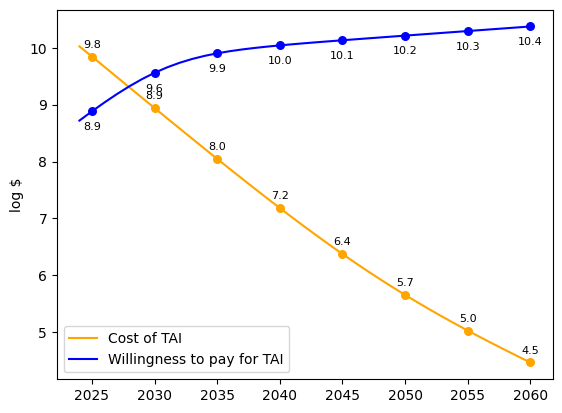

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 37.2 log FLOP (~15.8 thousand decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~133.6 sextillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~389.2 million).
* This doubles every 4.0 year to a max of 0.069182% of GDP (initially ~17.4 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 37.2 logFLOP which costs 19.0 log 2024$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2024-log-eFLOP)
2025 - TAI takes 37.0 logFLOP which costs 18.7 log 2024$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.2 2024-log-eFLOP)
2026 - TAI takes 36.8 logFLOP which costs 18.4 log 2024$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 27.6 2024-log-eFLOP)
2027 - TAI takes 36.6 logFLOP 

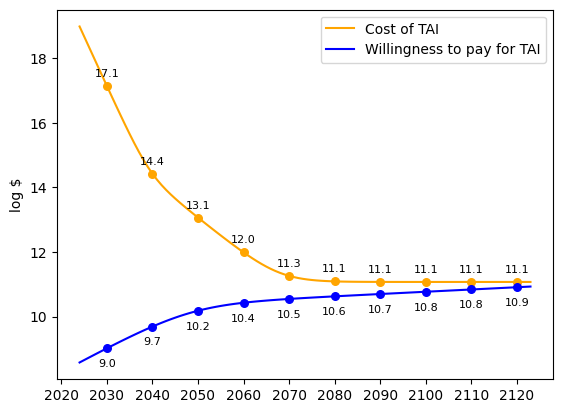

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 32.9 log FLOP (~794.3 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~502.8 quadrillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~236.5 septillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~313.2 million).
* This doubles every 5.8 year to a max of 0.132689% of GDP (initially ~33.1 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 32.9 logFLOP which costs 15.2 log 2024$USD to buy vs. WTP at 8.5 (buys 26.2 log FLOP or 26.2 2024-log-eFLOP)
2025 - TAI takes 32.7 logFLOP which costs 14.9 log 2024$USD to buy vs. WTP at 8.5 (buys 26.4 log FLOP or 26.6 2024-log-eFLOP)
2026 - TAI takes 32.5 logFLOP which costs 14.6 log 2024$USD to buy vs. WTP at 8.6 (buys 26.5 log FLOP or 26.9 2024-log-eFLOP)
2027 - TAI takes 32.3 logFLOP which 

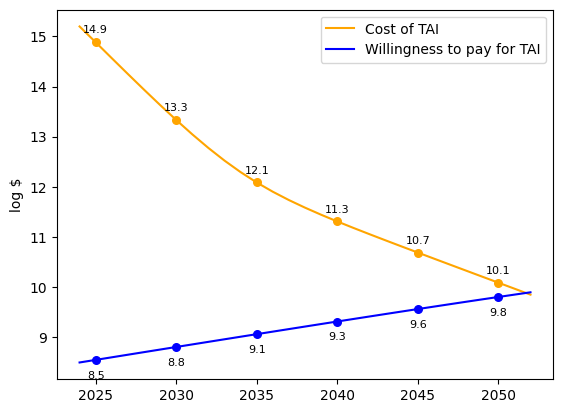

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 32.4 log FLOP (~251.2 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~89.8 septillion) per 2024$USD.
* We are initially willing to pay 8.4 log 2024$USD (~250.5 million).
* This doubles every 10.8 year to a max of 0.348082% of GDP (initially ~87.0 billion 2024$USD).
* GDP grows at a rate of 1.024x per year.
---
2024 - TAI takes 32.4 logFLOP which costs 13.9 log 2024$USD to buy vs. WTP at 8.4 (buys 26.9 log FLOP or 26.9 2024-log-eFLOP)
2025 - TAI takes 32.1 logFLOP which costs 13.5 log 2024$USD to buy vs. WTP at 8.4 (buys 27.1 log FLOP or 27.3 2024-log-eFLOP)
2026 - TAI takes 31.8 logFLOP which costs 13.1 log 2024$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.8 2024-log-eFLOP)
2027 - TAI takes 31.5 logFLOP which co

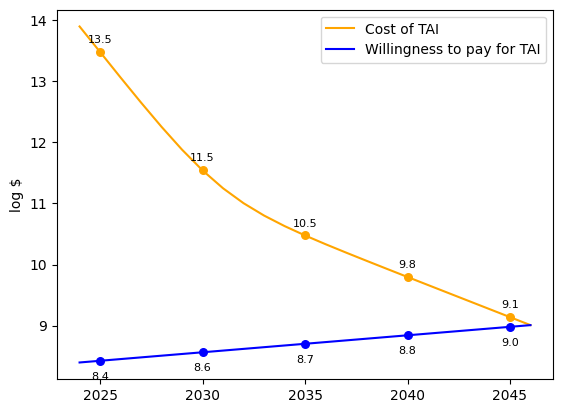

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 31.0 log FLOP (~10.0 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.8 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.6 sextillion) per 2024$USD.
* We are initially willing to pay 9.6 log 2024$USD (~4.1 billion).
* This doubles every 2.0 year to a max of 0.045024% of GDP (initially ~11.3 billion 2024$USD).
* GDP grows at a rate of 1.018x per year.
---
2024 - TAI takes 31.0 logFLOP which costs 12.1 log 2024$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.4 2024-log-eFLOP)
2025 - TAI takes 30.7 logFLOP which costs 11.6 log 2024$USD to buy vs. WTP at 9.6 (buys 28.6 log FLOP or 29.0 2024-log-eFLOP)
2026 - TAI takes 30.3 logFLOP which costs 11.1 log 2024$USD to buy vs. WTP at 9.7 (buys 28.9 log FLOP or 29.6 2024-log-eFLOP)
2027 - TAI takes 30.0 logFLOP which costs 1

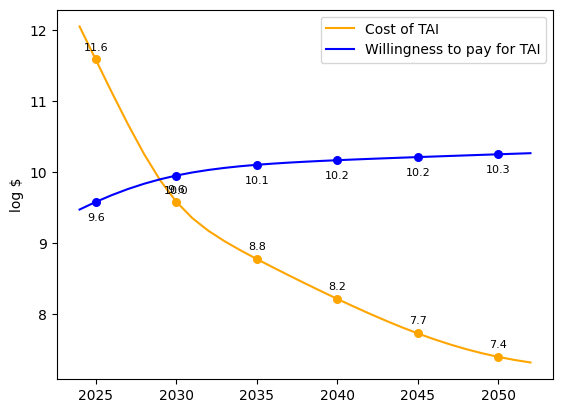

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.1 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~410.4 quintillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~1.8 billion).
* This doubles every 5.7 year to a max of 0.025% of GDP (initially ~6.2 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 29.5 logFLOP which costs 10.4 log 2024$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.3 2024-log-eFLOP)
2025 - TAI takes 29.4 logFLOP which costs 10.2 log 2024$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 29.2 logFLOP which costs 9.9 log 2024$USD to buy vs. WTP at 9.2 (buys 28.6 log FLOP or 28.8 2024-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs 9

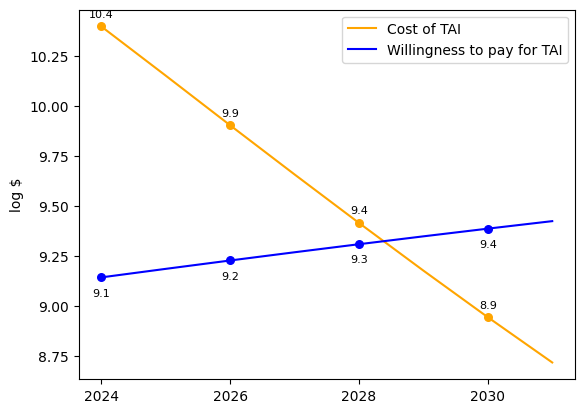

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.0 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 28.7 log FLOP (~50.3 octillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.4 billion).
* This doubles every 5.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.011x per year.
---
2024 - TAI takes 33.0 logFLOP which costs 14.0 log 2024$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.2 2024-log-eFLOP)
2025 - TAI takes 32.7 logFLOP which costs 13.6 log 2024$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 28.7 2024-log-eFLOP)
2026 - TAI takes 32.4 logFLOP which costs 13.2 log 2024$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 29.1 2024-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 12.

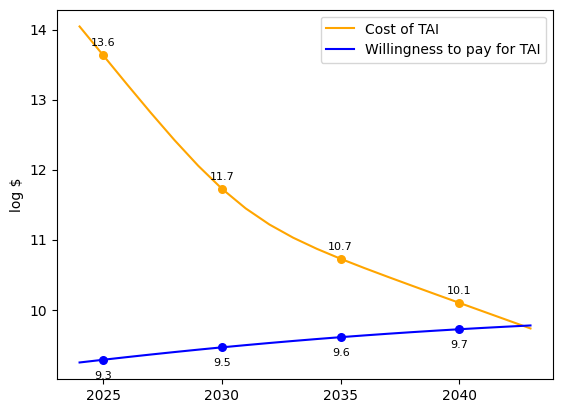

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 36.9 log FLOP (~7.9 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~20.9 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~585.4 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~591.3 million).
* This doubles every 8.3 year to a max of 0.037456% of GDP (initially ~9.4 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 36.9 logFLOP which costs 17.6 log 2024$USD to buy vs. WTP at 8.7 (buys 28.1 log FLOP or 28.1 2024-log-eFLOP)
2025 - TAI takes 36.3 logFLOP which costs 16.9 log 2024$USD to buy vs. WTP at 8.8 (buys 28.2 log FLOP or 28.8 2024-log-eFLOP)
2026 - TAI takes 35.7 logFLOP which costs 16.2 log 2024$USD to buy vs. WTP at 8.8 (buys 28.4 log FLOP or 29.5 2024-log-eFLOP)
2027 - TAI takes 35.2 logFLOP w

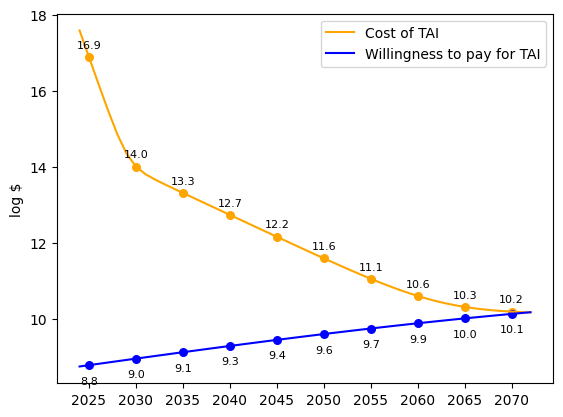

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 24.0 log FLOP (~1000.0 sextillion) for transformative capabilities.
* Every 3.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.5 septillion) per 2024$USD.
* We are initially willing to pay 8.4 log 2024$USD (~241.5 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 24.0 logFLOP which costs 5.5 log 2024$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 26.8 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur

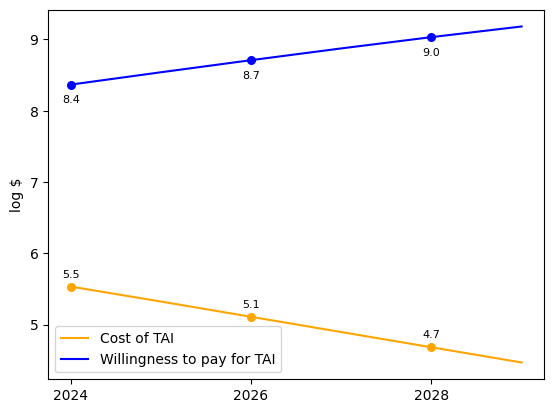

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~21.9 quintillion) per 2024$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2024$USD.
* We are initially willing to pay 8.2 log 2024$USD (~158.0 million).
* This doubles every 3.4 year to a max of 0.185043% of GDP (initially ~46.9 billion 2024$USD).
* GDP grows at a rate of 1.013x per year.
---
2024 - TAI takes 34.0 logFLOP which costs 14.7 log 2024$USD to buy vs. WTP at 8.2 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 33.6 logFLOP which costs 14.1 log 2024$USD to buy vs. WTP at 8.3 (buys 27.7 log FLOP or 28.1 2024-log-eFLOP)
2026 - TAI takes 33.2 logFLOP which costs 13.6 log 2024$USD to buy vs. WTP at 8.4 (buys 27.9 log FLOP or 28.7 2024-log-eFLOP)
2027 - TAI takes 32.8 logFLOP which cost

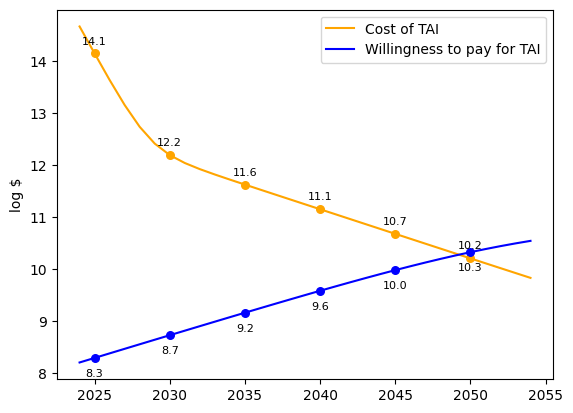

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 31.1 log FLOP (~12.6 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~408.6 sextillion) per 2024$USD.
* We are initially willing to pay 9.1 log 2024$USD (~1.2 billion).
* This doubles every 4.5 year to a max of 0.109475% of GDP (initially ~27.3 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 31.1 logFLOP which costs 13.1 log 2024$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.1 2024-log-eFLOP)
2025 - TAI takes 30.7 logFLOP which costs 12.5 log 2024$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.7 2024-log-eFLOP)
2026 - TAI takes 30.2 logFLOP which costs 12.0 log 2024$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 28.3 2024-log-eFLOP)
2027 - TAI takes 29.8 logFLOP which costs

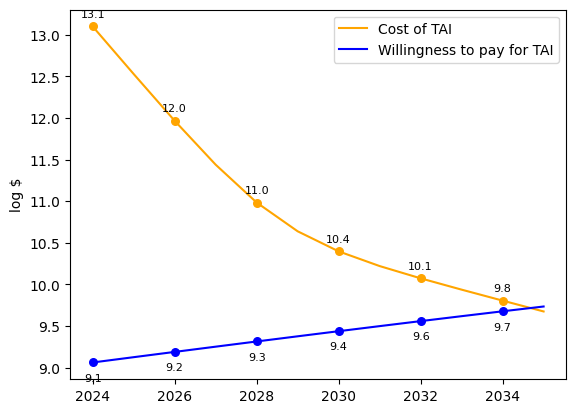

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 43.9 log FLOP (~79.4 billion decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.6 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~220.0 sextillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~313.7 million).
* This doubles every 1.2 year to a max of 0.152783% of GDP (initially ~38.6 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 43.9 logFLOP which costs 24.8 log 2024$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.6 2024-log-eFLOP)
2025 - TAI takes 43.4 logFLOP which costs 24.2 log 2024$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.4 2024-log-eFLOP)
2026 - TAI takes 42.9 logFLOP which costs 23.6 log 2024$USD to buy vs. WTP at 9.0 (buys 28.3 log FLOP or 29.3 2024-log-eFLOP)
2027 - TAI takes 42.5 logFLOP 

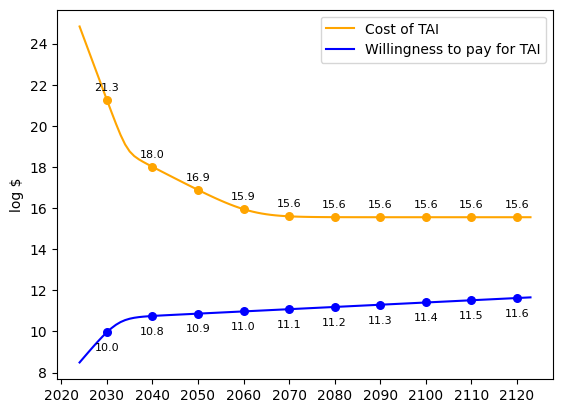

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 50.4 log FLOP (~251.2 quadrillion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 5.3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2024$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~38.1 septillion) per 2024$USD.
* We are initially willing to pay 9.9 log 2024$USD (~8.1 billion).
* This doubles every 3.2 year to a max of 0.091525% of GDP (initially ~22.9 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 50.4 logFLOP which costs 32.1 log 2024$USD to buy vs. WTP at 9.8 (buys 28.1 log FLOP or 28.1 2024-log-eFLOP)
2025 - TAI takes 50.1 logFLOP which costs 31.7 log 2024$USD to buy vs. WTP at 9.8 (buys 28.3 log FLOP or 28.6 2024-log-eFLOP)
2026 - TAI takes 49.8 logFLOP which costs 31.3 log 2024$USD to buy vs. WTP at 9.9 (buys 28.5 log FLOP or 29.0 2024-log-eFLOP)
2027 - TAI takes 49.6 logFL

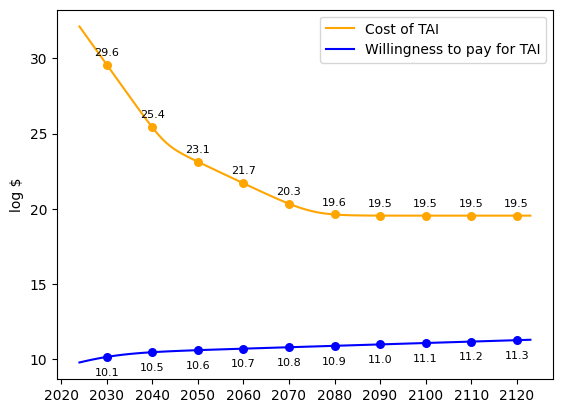

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 33.8 log FLOP (~6.3 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19.5 sextillion) per 2024$USD.
* We are initially willing to pay 8.0 log 2024$USD (~98.4 million).
* This doubles every 3.6 year to a max of 0.02505% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.014x per year.
---
2024 - TAI takes 33.8 logFLOP which costs 15.3 log 2024$USD to buy vs. WTP at 8.0 (buys 26.5 log FLOP or 26.5 2024-log-eFLOP)
2025 - TAI takes 33.3 logFLOP which costs 14.7 log 2024$USD to buy vs. WTP at 8.1 (buys 26.7 log FLOP or 27.2 2024-log-eFLOP)
2026 - TAI takes 32.9 logFLOP which costs 14.1 log 2024$USD to buy vs. WTP at 8.2 (buys 26.9 log FLOP or 27.9 2024-log-eFLOP)
2027 - TAI takes 32.5 logFLOP which costs 13

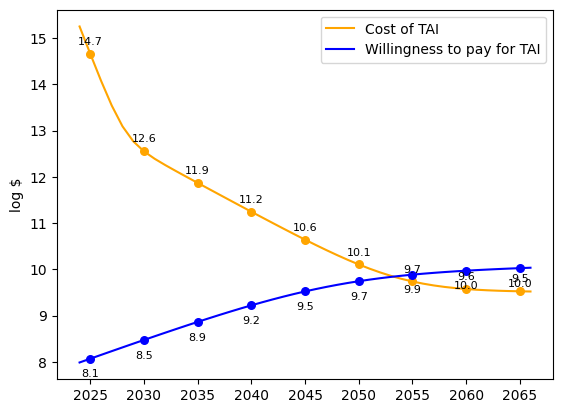

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 41.7 log FLOP (~501.2 million decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~7.0 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~239.1 sextillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~374.4 million).
* This doubles every 5.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.019x per year.
---
2024 - TAI takes 41.7 logFLOP which costs 22.9 log 2024$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 41.2 logFLOP which costs 22.2 log 2024$USD to buy vs. WTP at 8.6 (buys 27.6 log FLOP or 28.1 2024-log-eFLOP)
2026 - TAI takes 40.7 logFLOP which costs 21.6 log 2024$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 28.7 2024-log-eFLOP)
2027 - TAI takes 40.2 logFLOP whic

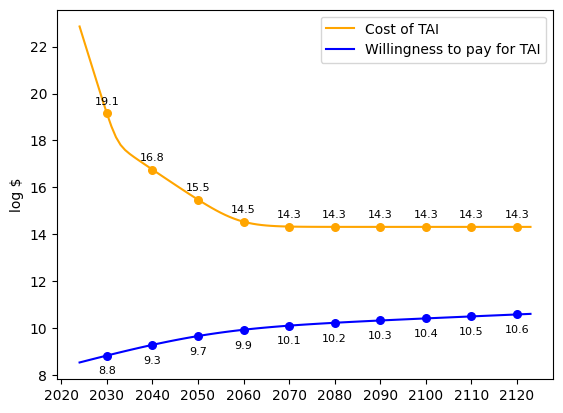

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 28.5 log FLOP (~31.6 octillion) for transformative capabilities.
* Every 3.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2024$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.2 septillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~704.7 million).
* This doubles every 2.6 year to a max of 0.025% of GDP (initially ~6.2 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 28.5 logFLOP which costs 9.9 log 2024$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 28.4 logFLOP which costs 9.7 log 2024$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.7 2024-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 9.5 log 2024$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.0 2024-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 9.4 lo

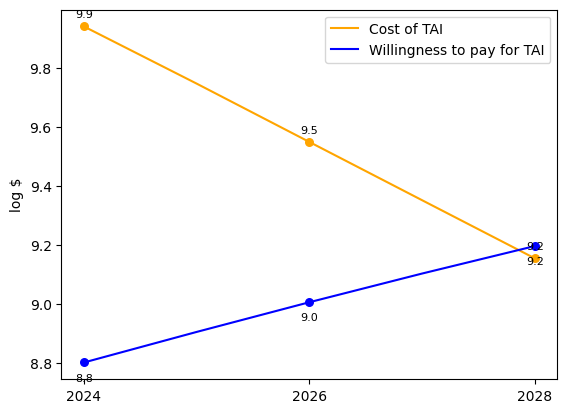

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 31.8 log FLOP (~63.1 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2024$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46.1 sextillion) per 2024$USD.
* We are initially willing to pay 9.1 log 2024$USD (~1.3 billion).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 31.8 logFLOP which costs 13.4 log 2024$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 31.4 logFLOP which costs 12.9 log 2024$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 28.1 2024-log-eFLOP)
2026 - TAI takes 31.0 logFLOP which costs 12.4 log 2024$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 28.7 2024-log-eFLOP)
2027 - TAI takes 30.6 logFLOP which costs 11.9

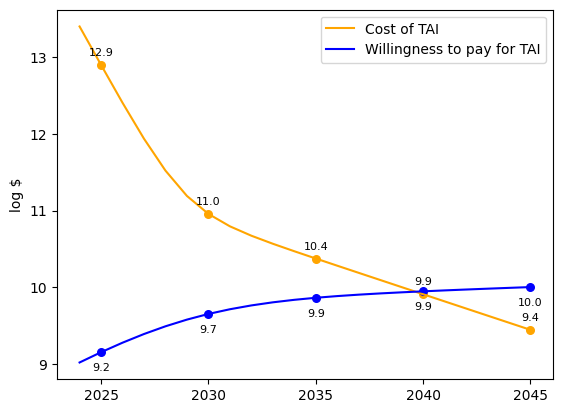

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 35.9 log FLOP (~794.3 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2.2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2024$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13.3 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~621.2 million).
* This doubles every 0.9 year to a max of 0.159751% of GDP (initially ~40.4 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 35.9 logFLOP which costs 17.4 log 2024$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.3 2024-log-eFLOP)
2025 - TAI takes 35.6 logFLOP which costs 16.9 log 2024$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.1 2024-log-eFLOP)
2026 - TAI takes 35.3 logFLOP which costs 16.4 log 2024$USD to buy vs. WTP at 9.4 (buys 28.3 log FLOP or 28.9 2024-log-eFLOP)
2027 - TAI takes 35.0 logFLOP which c

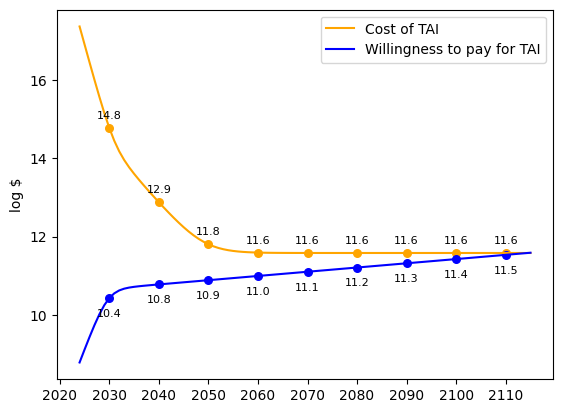

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 25.1 log FLOP (~12.6 septillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~17.3 septillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~301.0 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.024x per year.
---
2024 - TAI takes 25.1 logFLOP which costs 6.4 log 2024$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 9 years)


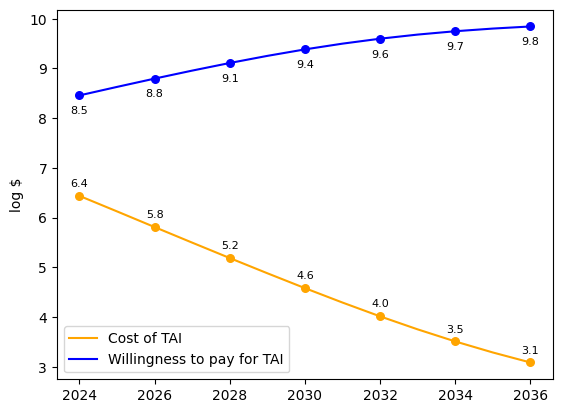

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-03-18 14:39:25.473794
